# Trial 1: learning graph filters

1. Random kNN graph: $W \in \mathbb{R}^{M \times M} \rightarrow L \rightarrow U, \Lambda$.
2. Random graph signals: $X = \{x_i\}_{i=1}^N \in \mathbb{R}^{M \times N}$.
3. Linear mapping: $f(x_i, c) = U \operatorname{diag}(c) U^T x_i$.
4. Noisy target signals: $Y = \{y_i\}_{i=1}^N \in \mathbb{R}^{M \times N}, y_i = f(x_i, c_{gt}) + \mathcal{N}_M(0,\epsilon)$.
    1. With randomly generated coefficients $c_{gt} \sim \mathcal{N}_M(0,1)$.
5. Convex and smooth loss function: $L = \frac{1}{N} \sum_{i=1}^N \|f(x_i, c) - y_i\|_2^2 = \frac{1}{N} \|U \operatorname{diag}(c) U^TX - Y\|_F^2$.
    1. Gradient: $\nabla_{c} L = \frac{2}{N} \left(U^T X \odot ( c \odot U^T X - U^T Y ) \right) 1_N$.
6. Optimization: $c^* = \operatorname{arg min}_c L(c)$.
7. Verification.
    1. $c^*$ should converge to $c_{gt}$.
    2. The loss $L(c^*)$ should converge to $L(c_{gt})$.

### Ref https://figshare.com/articles/presentation/Deep_Learning_on_Graphs/4491686?file=7253636


In [35]:
import time
import numpy as np
import scipy.sparse, scipy.sparse.linalg, scipy.spatial.distance
import matplotlib.pyplot as plt
%matplotlib inline
tol = 1e-10

## Problem setting

### Graph weight matrix

* A completely random graph is not smooth at all and will thus have a large spectral gap, i.e. $\lambda_1 >> \lambda_0$.
* A grid, on the contrary, is very regular.

In [36]:
M = 100  # nodes
k = 4  # edges per vertex

def graph_random():
    """Random connections and weights."""
    I = np.arange(0, M).repeat(k)
    J = np.random.randint(0, M, M*k)
    V = np.random.uniform(0, 1, M*k)
    W = scipy.sparse.coo_matrix((V, (I, J)), shape=(M, M))
    return graph_regularize(W)

def graph_grid():
    """Construct a kNN graph aranged on a 2D grid."""
    
    # Construct a grid.
    m = np.int(np.sqrt(M))
    x = np.linspace(0,1,m)
    y = np.linspace(0,1,m)
    xx, yy = np.meshgrid(x, y)
    z = np.empty((M,2))
    z[:,0] = xx.reshape(M)
    z[:,1] = yy.reshape(M)

    # Compute pairwise distances.
    d = scipy.spatial.distance.pdist(z, 'euclidean')
    d = scipy.spatial.distance.squareform(d)

    # k-NN graph.
    idx = np.argsort(d)[:,1:k+1]
    d.sort()
    d = d[:,1:k+1]

    # Weights.
    sigma2 = np.mean(d[:,-1])**2
    d = np.exp(- d**2 / sigma2)

    # Weight matrix.
    I = np.arange(0, M).repeat(k)
    J = idx.reshape(M*k)
    V = d.reshape(M*k)
    W = scipy.sparse.coo_matrix((V, (I, J)), shape=(M, M))
    return graph_regularize(W)

def graph_regularize(W):
    # No self-connections.
    W.setdiag(0)

    # Non-directed graph.
    bigger = W.T > W
    W = W - W.multiply(bigger) + W.T.multiply(bigger)
    del bigger
    assert np.abs(W - W.T).mean() < tol

    # CSR sparse matrix format for efficient multiplications.
    W = W.tocsr()
    W.eliminate_zeros()
    
    return W

W = graph_random()
W = graph_grid()
print("{} > {} edges".format(W.nnz, M*k))

438 > 400 edges


/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/2629621943.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.int(np.sqrt(M))


### Graph Laplacian

* $L^\text{unnormalized} = D - W$
* $L^\text{normalized} = I - D^{-1/2} W D^{-1/2}$

Upper-bound approximation of the spectrum.

* Computed by the Implicitly Restarted Lanczos Method (IRLM), which is a reduction of a variant of the Arnoldi iteration. It is faster than the Power method.
* Normalized graph Laplacian has a bounded spectrum $0 \leq \lambda \leq 2$.
* `eigs` is faster than `eigsh`. There are also non-sparse routines in `scipy.linalg`.

In [37]:
def laplacian(W, normalized=True):
    """Return the Laplacian of the weigth matrix."""
    
    # Degree matrix.
    d = W.sum(axis=0)

    # Laplacian matrix.
    if not normalized:
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        L = D - W
    else:
        d = 1 / np.sqrt(d)
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        I = scipy.sparse.identity(M, dtype=D.dtype)
        L = I - D * W * D
    
    # Upper-bound on the spectrum.
    lmax = scipy.sparse.linalg.eigsh(L, k=1, which='LM', return_eigenvectors=False)[0]
    if normalized:
        assert lmax <= 2
        lmax = 2
    
    return L, lmax

t_start = time.process_time()
LL, lmax = laplacian(W, True)
print('Execution time: {:1.0f}ms'.format((time.process_time() - t_start) * 1000))
assert np.abs(LL - LL.T).mean() < tol

Execution time: 4ms


### Fourier basis

$L = U^T \Lambda U$ where $\Lambda$ is a diagonal matrix of eigenvalues.
Compare the results of four algorithms.

/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/389259829.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.int(np.sqrt(M))


Execution time: 4ms
Spectrum: [3.78e-16, 1.93e+00]


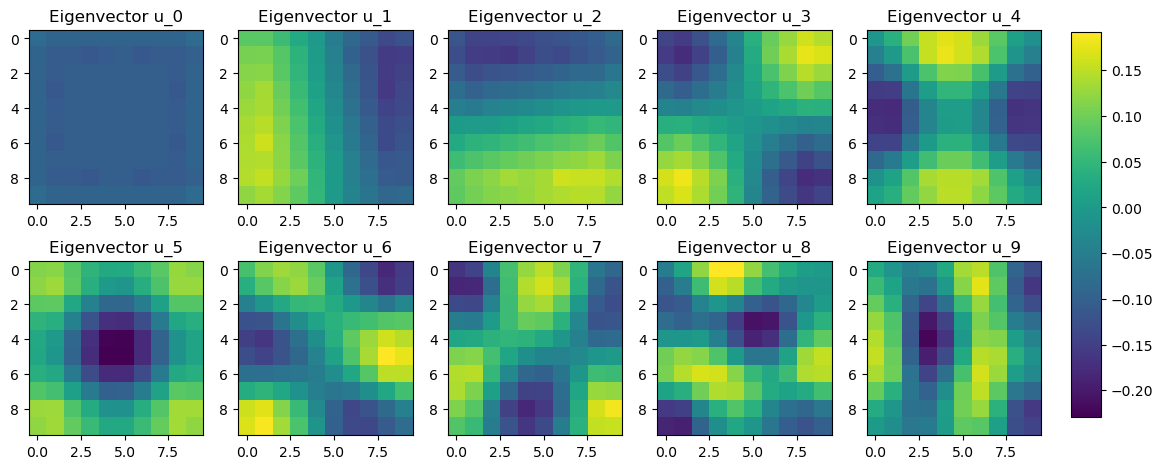

In [38]:
def fourier(L):

    def sort(lamb, U):
        idx = lamb.argsort()
        return lamb[idx], U[:,idx]

    t_start = time.process_time()
    lamb, U = np.linalg.eig(LL.toarray())
    lamb, U = sort(lamb, U)
    print('Execution time: {:1.0f}ms'.format((time.process_time() - t_start) * 1000))

    # Orthonormal basis: all basis vectors are of length one (unit energy).
    np.testing.assert_allclose(np.linalg.norm(U, axis=0), np.ones(M))
    np.testing.assert_allclose(np.linalg.norm(U, axis=1), np.ones(M))
    
    if M <= 100:  # Because of the computational complexity.
        
        lamb_, U_ = np.linalg.eigh(LL.toarray())
        np.testing.assert_allclose(lamb_, lamb, atol=tol)
        np.testing.assert_allclose(np.abs(U_), np.abs(U), atol=tol)

        lamb_, U_ = scipy.sparse.linalg.eigs(LL, k=M-2, which='SM')
        lamb_, U_ = sort(lamb_, U_)
        np.testing.assert_allclose(lamb[:-2], lamb_, atol=tol)
        np.testing.assert_allclose(np.abs(U[:,:-2]), np.abs(U_), atol=tol)

        lamb_, U_ = scipy.sparse.linalg.eigsh(LL, k=M-1, which='SM')
        np.testing.assert_allclose(lamb[:-1], lamb_, atol=tol)
        np.testing.assert_allclose(np.abs(U[:,:-1]), np.abs(U_), atol=tol)
    
    return lamb, U

lamb, U = fourier(LL)

print('Spectrum: [{:1.2e}, {:1.2e}]'.format(lamb[0], lamb[-1]))
np.testing.assert_allclose(lamb[0], 0, atol=tol)
assert lamb[-1] <= lmax + tol

def plot_eigenvectors(U, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols, figsize=(15,5.5))
    m = np.int(np.sqrt(M))
    n = nrows * ncols
    vmin, vmax = U[:,:n].min(), U[:,:n].max()
    for i, ax in enumerate(axes.flat):
        x = np.reshape(U[:,i], (m,m))
        im = ax.imshow(x, vmin=vmin, vmax=vmax)
        ax.set_title('Eigenvector u_{}'.format(i))
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.82, 0.16, 0.02, 0.7])
    fig.colorbar(im, cax=cax)
    plt.show()
plot_eigenvectors(U, 2, 5)

### Ground truth graph filter

Linear mapping $f(x_i, c) = U C U^T x_i$, $C$ is the diagonal matrix $C = \operatorname{diag}(c)$, i.e. $c = C 1_M$.

* Parametrized low-pass filter coefficients $(c_{gt})_i = \operatorname{e}^{-t \lambda_i}$
* Random filter coefficients $c_{gt} \sim \mathcal{N}_M(0,1)$

<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/2205654100.py:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if type is 'random':
/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/2205654100.py:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif type is 'step':
/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/220565

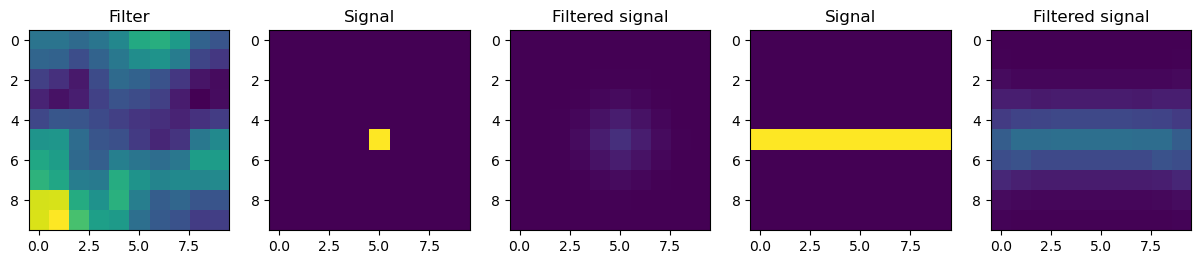

Filter energy E = 58.8


In [39]:
def gen_filter(type='step', t=2):
    if type is 'random':
        return np.random.normal(0, 1, M), None
    elif type is 'step':
        g = lambda x: np.minimum(np.array(x < lmax/2) + 0.5, 1)
    elif type is 'sin':
        g = lambda x: np.sin(t * (x-2)**2)
    elif type is 'heat':
        g = lambda x: np.exp(-t * x)
    elif type is 'hat':
        g = lambda x: t * x * np.exp(-x**2)
    return g(lamb), g
c_g, g = gen_filter('step', 6)

def filter_full(X, c):
    """Filter X with a full spectral domain filter."""
    return U @ np.diag(c) @ U.T @ X

def plot_filtering(*args):
    m = np.int(np.sqrt(M))
    c = gen_filter(*args)[0]

    x1 = np.zeros((m,m))
    x2 = np.zeros((m,m))
    x1[5,5] = 1
    x2[5,:] = 1
    x1.shape = M
    x2.shape = M

    fig, axes = plt.subplots(1,5, figsize=(15,5))
    
    axes[0].imshow((U @ c).reshape((m,m)))
    axes[0].set_title('Filter')
    
    for i, x in enumerate([x1, x2]):
        axes[2*i+1].imshow(x.reshape((m,m)), vmin=0, vmax=1)
        axes[2*i+1].set_title('Signal')
        y = filter_full(x, c)
        axes[2*i+2].imshow(y.reshape((m,m)), vmin=0, vmax=1)
        axes[2*i+2].set_title('Filtered signal')
    plt.show()

plot_filtering('heat', 3)

# Parseval (energy preservation).
E = np.linalg.norm(c_g)**2
print('Filter energy E = {:.1f}'.format(E))
np.testing.assert_allclose(np.linalg.norm(U @ c_g)**2, E)

### Graph signals

* Random input signals $X \sim \mathcal{N}_{M \times N}(0,1)$
  * Low-pass signals ?
* Noisy target signals $y_i = f(x_i, c_{gt}) + \mathcal{N}_M(0,\epsilon)$

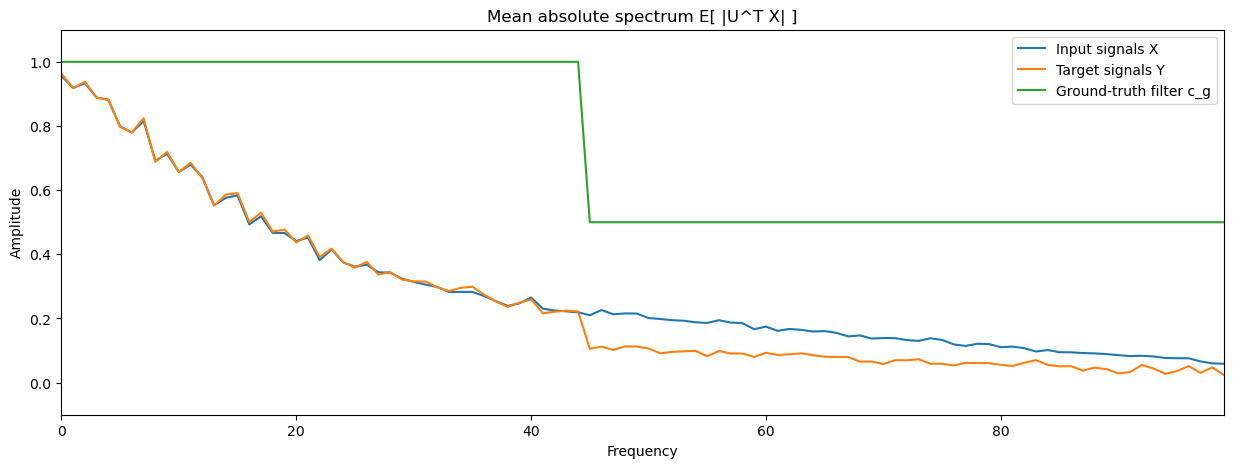

In [40]:
N = 200  # signals
eps = 0.1  # noise

def gen_signal(spectral_mean):
    Xf = np.empty((M,N))
    for m in range(M):
        a = spectral_mean[m]
        Xf[m,:] = np.random.normal(a, a/2, N)
    return U @ Xf

X = np.random.normal(0, 1, (M,N))
X = gen_signal(np.exp(-1.5*lamb))
np.testing.assert_allclose(filter_full(X, np.ones(M)), X, atol=tol)

Y = filter_full(X, c_g) + (np.random.normal(0, eps, (M,N)) if eps > 0 else 0)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.plot(np.abs(np.mean((U.T @ X), axis=1)), label='Input signals X')
ax.plot(np.abs(np.mean((U.T @ Y), axis=1)), label='Target signals Y')
ax.plot(c_g, label='Ground-truth filter c_g')
ax.legend()
ax.set_title('Mean absolute spectrum E[ |U^T X| ]')
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude')
ax.set_xlim(0, M-1)
ax.set_ylim(-.1, 1.1)
plt.show()

## Non-parametrized filter learning

### Loss function

* Loss function $L = \frac{1}{N} \sum_{i=1}^N \|f(x_i, c) - y_i\|_2^2 = \frac{1}{N} \|UCU^TX - Y\|_F^2$.
    * Spectral domain: $L = \frac{1}{N} \| C U^T X - U^T Y \|_F^2$.
    * Independant coefficients: $L = \frac{1}{N} \sum_{i=1}^M \| c_i (U^T X)_{i,\cdot} - (U^T Y)_{i,\cdot} \|_2^2$.
    * Convex and smooth w.r.t. $c$.
* Gradient:
    * Independant coefficients: $\nabla_{c_i} L = \frac{2}{N} ( c_i (U^T X)_{i,\cdot} - (U^T Y)_{i,\cdot} ) (X^T U)_{\cdot,i}$.
    * $\nabla_{c} L = \frac{2}{N} \left(U^T X \odot ( c \odot U^T X - U^T Y ) \right) 1_N$.
* Optimization $c^* = \operatorname{arg min}_{c} L(c)$

In [41]:
def L(c):
    M, N = X.shape
    return np.linalg.norm(filter_full(X, c) - Y, ord='fro')**2 / N
np.testing.assert_allclose(L(c_g), M * eps**2, 5e-2)

def dL(X, Y, c, variant=None):
    M, N = X.shape
    Xh = U.T @ X
    Yh = U.T @ Y
    # Speed: v3 >> v1 > v2.
    if variant is 1:
        return 2 / N * np.diag((np.diag(c) @ Xh - Yh) @ Xh.T)
    elif variant is 2:
        dc = np.empty(M)
        for i in range(M):
            dc[i] = 2 / N * (c[i] * Xh[i,:] - Yh[i,:]) @ Xh.T[:,i]
        return dc
    else:
        # Speed: .sum(axis=1) is faster than *np.ones(N).
        return 2 / N * ((c[:,np.newaxis] * Xh - Yh) * Xh).sum(axis=1)
# Gradient should be null at the global minimum. With noise, c_g is not necessary the optimum.
if eps <= 0:
    np.testing.assert_allclose(dL(X, Y, c_g), 0, atol=tol)
np.testing.assert_allclose(dL(X, Y, c_g), dL(X, Y, c_g, 1))
np.testing.assert_allclose(dL(X, Y, c_g), dL(X, Y, c_g, 2))

<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/278220460.py:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if variant is 1:
/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/278220460.py:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif variant is 2:


### Optimization: optimality condition

* Only possible because $L$ is convex and smooth.
* Optimality condition $\nabla_c L = 0$ gives $(U^T X \odot U^T X) 1_N \odot c = (U^T X \odot U^T Y) 1_N$.

In [42]:
t_start = time.process_time()
Xh = U.T @ X
Yh = U.T @ Y
c_o = (Xh * Yh).sum(axis=1) / (Xh * Xh).sum(axis=1)
print('Execution time: {:1.0f}ms'.format((time.process_time() - t_start) * 1000))

assert L(c_o) < L(c_g) + tol
assert np.linalg.norm(dL(X, Y, c_o)) < np.linalg.norm(dL(X, Y, c_g))
np.testing.assert_allclose(dL(X, Y, c_o), 0, atol=tol)
if eps <= 0:
    np.testing.assert_allclose(c_o, c_g, atol=tol)
    np.testing.assert_allclose(L(c_o), L(c_g), atol=tol)

Execution time: 5ms


### Optimization: stochastic (mini-batch) gradient descent

* Works also for $L$ which are non-smooth (with sub-gradient) or non-convex.
* Idea: descend the gradient of the loss function.
* Efficiency: compute the gradient $\nabla_c L$ with a sub-set (mini-batch) of the training data.
    * Extreme case: one sample at a time. Very inefficient.
* Update rule (gradient descent) $c^{n+1} = c^n - \lambda_n \nabla_c L$.
* Note: objective (loss on training set) and error (on validation set) are usually evaluated after each epoch. The algorithm is thus stopped after a maximum number of epochs rather than iterations.
* The convergence is $O(n^{-2})$.
* Hyper-parameters.
    * Learning rate (step size) $\lambda_n$. Bigger the batch size, smaller the learning rate.
        * Tradeoff.
            * Small: progress is steady but slow.
            * Big: risks of oscillations or divergence.
        * There are tricks, e.g. vanishing step (like simulated annealing).
    * Size of the mini-batch.
        * We want the one who minimizes the *training time*.
        * Trade-off: should be limited by the available memory, somewhere around 100.
            * Larger is more stable, but computationnaly more expensive.
            * Smaller demands more accesses to memory, which is slow.
            * Larger exploits the parallelism of modern hardware architectures (SIMD on CPU, GPU).
        * Extreme cases:
            * $1$: stochastic gradient descent.
            * $N$: gradient descent.
    * Stopping criterion.
        * Convergence of the loss function $L$.
        * Convergence of the parameters $c$.
        * Maximum number of iterations.

In [43]:
def sgd(c0, L, dL, learning_rate=.1, batch_size=100, crit=1e-3, maxit=100, window=10):
    """Stochastic (mini-batch) gradient descent."""
    indices = []
    c = c0
    loss = [L(c)]
    conv = []
    
    def stop(loss):
        """Stop after convergence of the loss."""
        if len(loss) > maxit:
            return True
        #elif np.linalg.norm(dL(X, Y, c)) < crit:
            #return True
        elif len(loss) >= 2 * window:
            avg1 = np.mean(loss[-window:])
            avg2 = np.mean(loss[-2*window:-window])
            return True if avg2 - avg1 < crit else False
        else:
            return False
    
    while not stop(loss):
        
        # Be sure to have used all the samples before using one a second time.
        if len(indices) < batch_size:
            new_indices = np.arange(N)
            np.random.shuffle(new_indices)
            indices.extend(new_indices)
        idx = indices[:batch_size]
        del indices[:batch_size]
        
        c_last = c.copy()
        n = len(loss)  # Used when evaluating learning_rate
        c -= eval(learning_rate) * dL(X[:,idx], Y[:,idx], c)
        loss.append(L(c))
        conv.append(np.linalg.norm(c - c_last) / np.linalg.norm(c))
        
    return c, loss, conv

def rate(rate0, a, k):
    """Decaying learning rate w.r.t. iteration k."""
    return rate0 / (1 + a * rate0 * k)

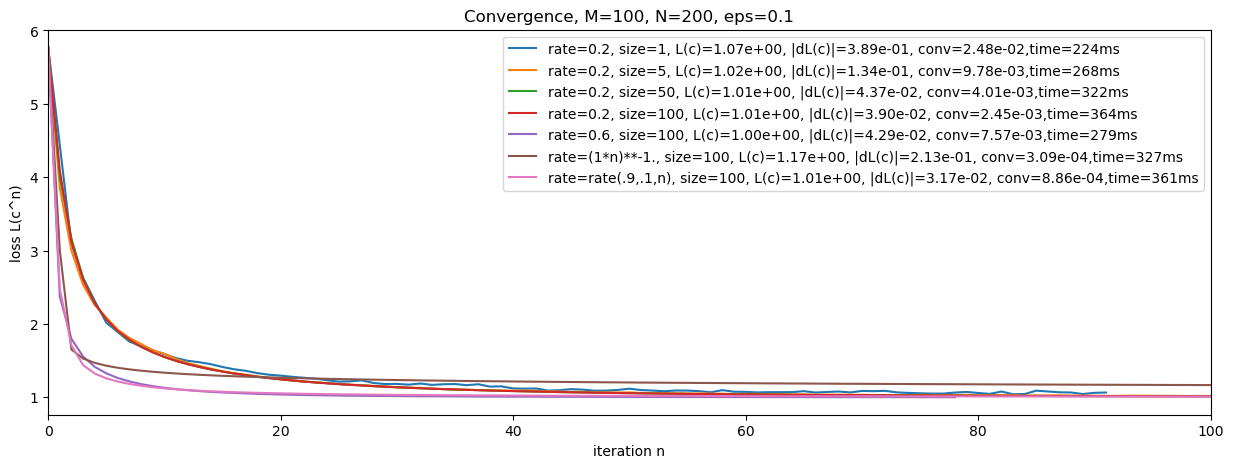

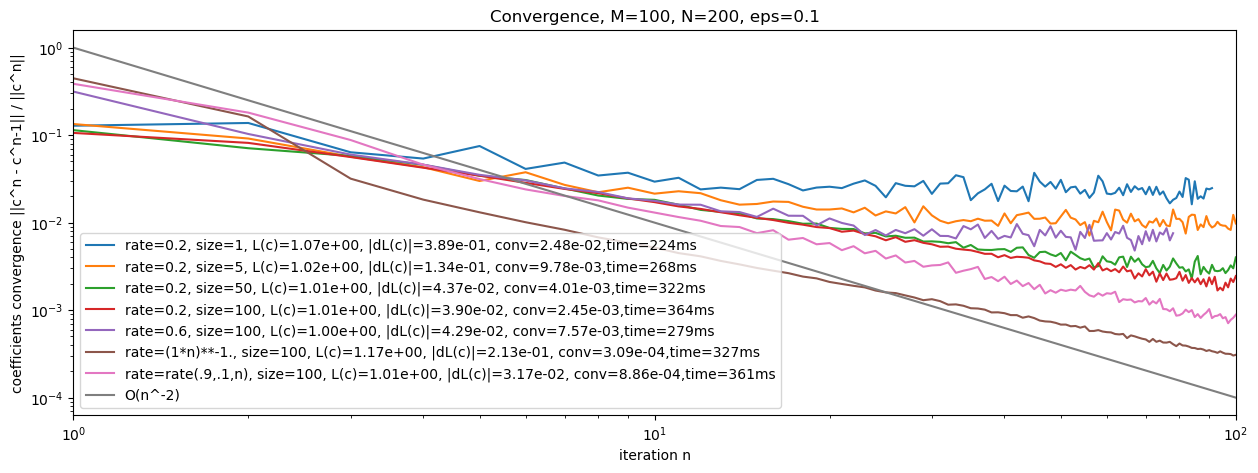

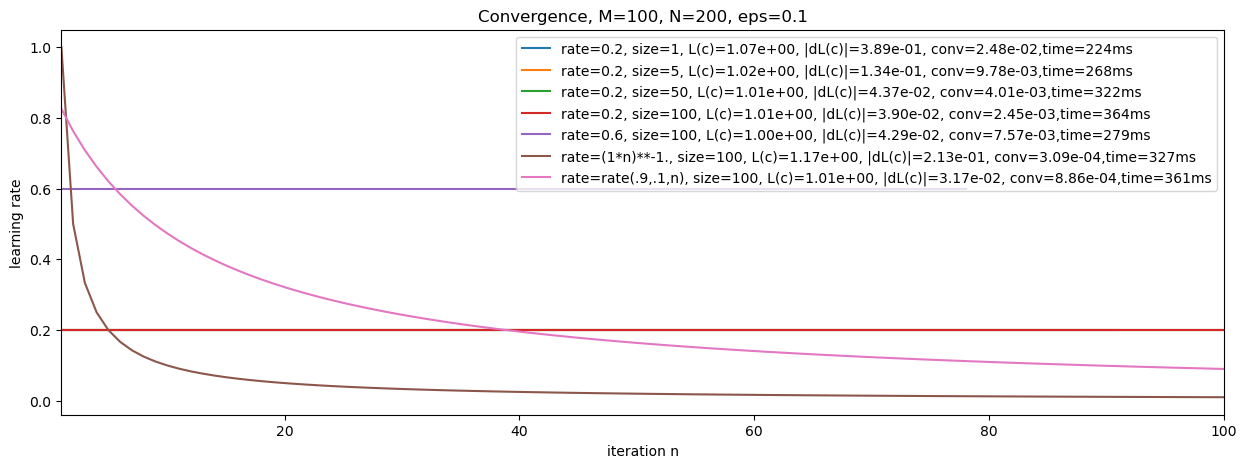

In [44]:
def sgd_plot_convergence(c0, L, dL, params, crit, maxit):
    fig_loss = plt.figure(figsize=(15,5))
    fig_conv = plt.figure(figsize=(15,5))
    fig_rate = plt.figure(figsize=(15,5))
    ax_loss = fig_loss.add_subplot(1,1,1)
    ax_conv = fig_conv.add_subplot(1,1,1)
    ax_rate = fig_rate.add_subplot(1,1,1)

    c_sgd = []
    mlen = 0
    for param in params:
        t_start = time.process_time()
        c, loss, conv = sgd(c0.copy(), L, dL, param[0], param[1], crit, maxit)
        t = (time.process_time() - t_start) * 1000
        label = 'rate={}, size={}, L(c)={:1.2e}, |dL(c)|={:1.2e}, conv={:1.2e},time={:1.0f}ms'.format(
            param[0], param[1], L(c), np.linalg.norm(dL(X, Y, c)), conv[-1], t)
        n = np.arange(1, len(conv)+1)
        ax_loss.plot(loss, label=label)
        ax_conv.loglog(n, conv, label=label)
        learning_rate = eval(param[0])
        if not isinstance(learning_rate, np.ndarray):
            learning_rate *= np.ones(len(n))
        ax_rate.plot(n, learning_rate, label=label)
        c_sgd.append(c)
        mlen = max(mlen, len(loss))
        
    n = np.arange(1,mlen)
    ax_conv.semilogy(n, 1/n**2, label='O(n^-2)')
    
    for ax in ax_loss, ax_conv, ax_rate:
        ax.set_title('Convergence, M={}, N={}, eps={}'.format(M, N, eps))
        ax.set_xlabel('iteration n')
        ax.legend(loc='best')
    ax_loss.set_ylabel('loss L(c^n)')
    ax_conv.set_ylabel('coefficients convergence ||c^n - c^n-1|| / ||c^n||')
    ax_rate.set_ylabel('learning rate')
    ax_loss.set_xlim(0, mlen-1)
    ax_conv.set_xlim(1, mlen-1)
    ax_rate.set_xlim(1, mlen-1)
    plt.show()
    
    return c_sgd

params = []
params.append(['0.2', 1])
params.append(['0.2', 5])
params.append(['0.2', 50])
params.append(['0.2', 100])
params.append(['0.6', 100])
params.append(['(1*n)**-1.', 100])
params.append(['rate(.9,.1,n)', 100])
c0 = np.random.uniform(0, 1, M)
c_s = sgd_plot_convergence(c0, L, dL, params, crit=1e-3, maxit=100)

### Results: learned filters

Observations:
* Noise: why don't we find the same loss as the ground truth, but the same as linear programming ?
    * The gradient was incorrectly set to $\nabla_c L = \frac{2}{N} U^T X (X^T U c - Y^T U 1_M)$.
* More samples, e.g. $N=2000$: why don't we find the same loss as the linear program ?
    * Learning rate too high.
* The spectral gap $\lambda_1$ is large for a random graph.
* Without noise, the recovered filter is exact.

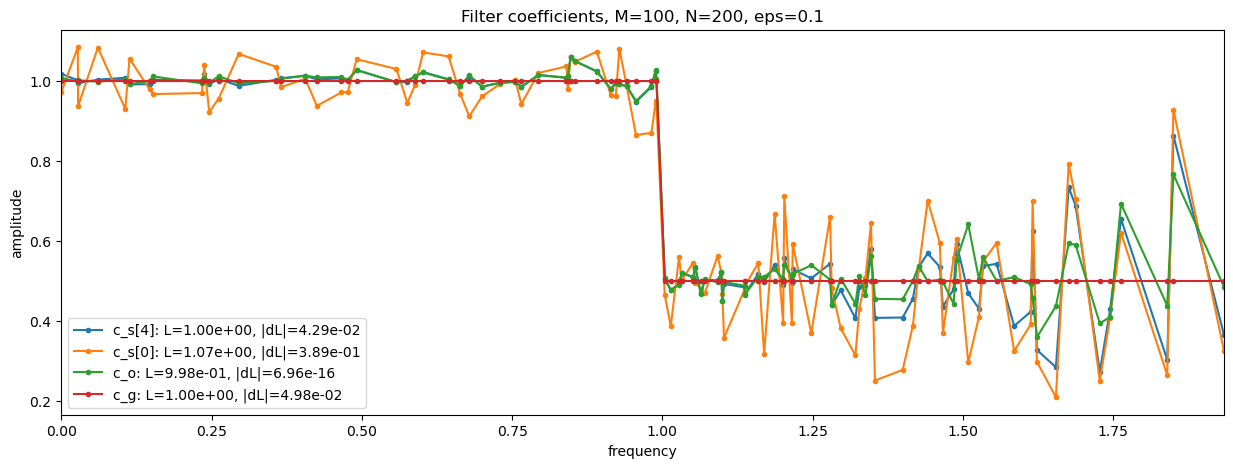

In [45]:
def plot_filters(coeffs):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,1,1)
    for coeff in coeffs:
        c = eval(coeff)
        label = '{}: L={:1.2e}, |dL|={:1.2e}'.format(coeff, L(c), np.linalg.norm(dL(X,Y,c)))
        ax.plot(lamb, c, '.-', label=label)
#        np.testing.assert_allclose(np.linalg.norm(c)**2, E, rtol=1e-2)
    ax.set_xlim(lamb[0], lamb[-1])
    ax.set_title('Filter coefficients, M={}, N={}, eps={}'.format(M, N, eps))
    ax.set_xlabel('frequency')
    ax.set_ylabel('amplitude')
    ax.legend(loc='best')

plot_filters(['c_s[4]', 'c_s[0]', 'c_o', 'c_g'])

## Parametrized filter learning: truncated Chebyshev expansion

* Use a $K$th order polynomial approximation of the filter.
* Less free parameters: $K << M$.
* Good approximation for smooth, i.e. localized, filters.

### Basis of Chebyshev polynomials

* Compute the Chebyshev basis $T$ of order $K$.
* This basis will allow us to construct and observe the filter from the inferred polynomial coefficients.
* The figure shows that we indeed generate the Chebyshev polynomials of the first kind.

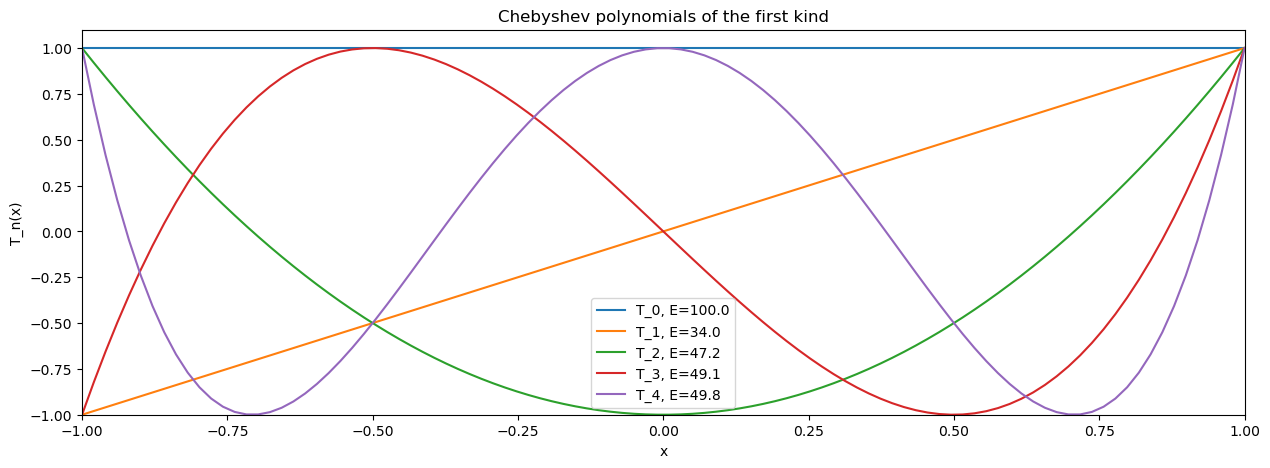

In [46]:
K = 5

def cheby_basis(K, x):
    """Return the Chebyshev basis of order K (composed of the
    first K polynomials) evaluated at x. Polynomials are generated
    by their recursive formulation."""
    T = np.empty((x.size, K))
    T[:,0] = np.ones(x.size)
    if K >= 2:
        T[:,1] = x
    for k in range(2, K):
        T[:,k] = 2 * x * T[:,k-1] - T[:,k-2]
#    T /= np.linalg.norm(T, axis=0)  # Scaling to unit norm.
    return T

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
x = np.linspace(-1,1,100)
T = cheby_basis(K, x)
for k in range(K):
    ax.plot(x, T[:,k], label='T_{}, E={:.1f}'.format(k, np.linalg.norm(T[:,k])**2))
ax.set_title('Chebyshev polynomials of the first kind')
ax.set_xlabel('x')
ax.set_ylabel('T_n(x)')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1.1)
ax.legend(loc='best')
plt.show()

### Ground truth Chebyshev expansion's coefficients

Given the filter $g$ with a vector $c_{gt} \in \mathbb{R}^M$ of evaluations, find the Chebyshev coefficients $c_{cgt} \in \mathbb{R}^K$. Truncated Chebyshev series closely approximate the minimax polynomial, i.e. $c_{cgt} \approx \operatorname{arg min}_c \| c_{gt} - \sum_k c_k T_k \|_\infty$ where $T_k$ is the Chebyshev polynomial of order $k$. Given that the polynomials form an orthogonal basis for $L^2([-1,1],\frac{dy}{\sqrt{1-y^r}})$, the coefficients can be retrieved by two methods.

1. Analytical projection.
    * $c_k = \frac{2}{\pi} \int_0^\pi \cos(k\theta) g( \frac{\lambda_{max}}{2} (\cos(\theta) + 1)) d\theta$
    * Need the analytic function.
2. Numerical projection (discrete orthogonality condition).
    * $c_k = \frac{2}{K} \sum_j g(x_j) T_k(x_j)$ where the $x_j$ are the $K$ Chebyshev nodes, because the approximation error is null only at these points.
    * Need function evaluations at the Chebyshev nodes, but those only. Much less points than least mean square.

In our setting, the generative filter is the function to learn. We have however access to some evaluations of the filter (at the eigenvalues of the Laplacian) via convex optimization of the loss function $L$ (described above). From those, given the Chebyshev basis, we can retrieve the coefficients that minimize the reconstruction error of this filter.

Results:

* Playing with the order $K$ shows that the approximation converges to the filter $g$.
* The approximation constructed by minimizing the filter l2 reconstruction error is now longer a Chebyshev polynomial (there are error on the Chebyshev nodes) but it provides a smaller loss $L$ (our final measure of quality).

/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/181514422.py:37: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_co = np.linalg.lstsq(T, c_g)[0]


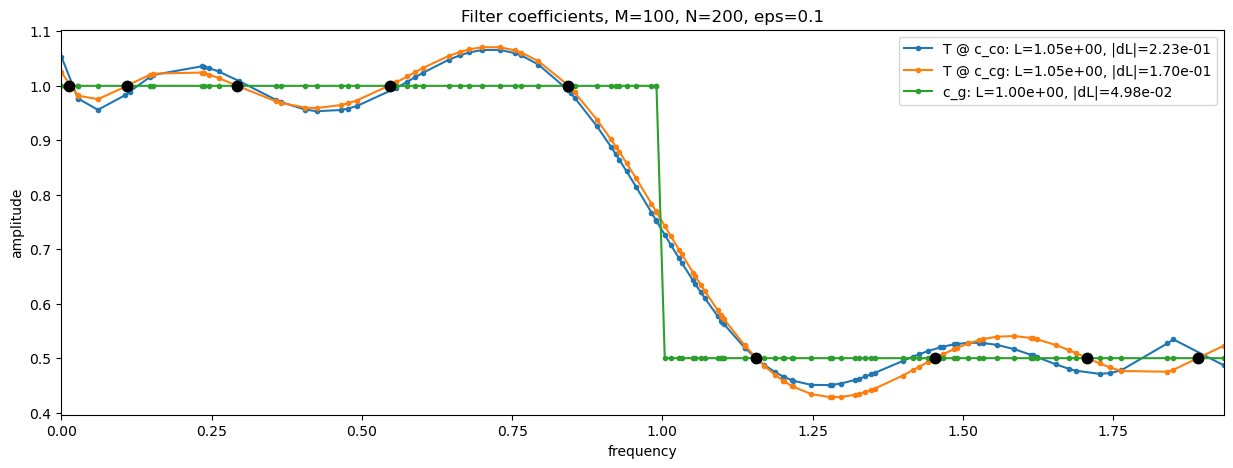

In [47]:
K = 10

def rescale(x, reverse=False):
    """Rescale the spectral domain to [-1,1]."""
    if reverse:
        return x / lmax * 2 - 1
    else:
        return (x + 1) / 2 * lmax
np.testing.assert_allclose(lamb, rescale(rescale(lamb, True)), atol=tol)

def cheby_nodes(K):
    """Return the K Chebyshev nodes in [-1,1]."""
    return np.cos(np.pi * (np.arange(K) + 1/2) / K)
    
def cheby_coeff(K, f):
    """Compute the coefficients of the Chebyshev polynomial approximation."""
    # Coefficients from discrete orthogonality condition.
    # It can be done faster via the discrete cosine transform.
    c = np.empty(K)
    x = cheby_nodes(K)
    T = cheby_basis(K, x)
    for k in range(K):
        c[k] = 2 / K * np.sum(f(x) * T[:,k])
    c[0] /= 2
    return c

# Domain is [-1, 1].
x = np.linspace(-1,1,100)
x = rescale(lamb, True)
f = lambda x: g(rescale(x))
np.testing.assert_allclose(f(x), c_g, atol=tol)

c_cg = cheby_coeff(K, f)
np.testing.assert_allclose(f(cheby_nodes(K)), cheby_basis(K, cheby_nodes(K)) @ c_cg)

T = cheby_basis(K, x)
c_co = np.linalg.lstsq(T, c_g)[0]

plot_filters(['T @ c_co', 'T @ c_cg', 'c_g'])
plt.plot(rescale(cheby_nodes(K)), f(cheby_nodes(K)), 'k.', markersize=15, label='Chebyshev nodes');

### Polynomial order

Determine the polynomial order by filtering the data with Chebyshev approximations of order $1 \leq k \leq K$ and monitoring the reconstruction loss $L$.

* The result shows that the approximation does indeed converge.
* The approximation loss arrives at a plateau (either the noise or the round-off error) given a high enough order.
* As anticipated on the figure above, the coefficients provided by least square reconstruction (which gives not really a Chebyshev interpolant) have smaller loss than the *correct* ones.
* The approximation error and the loss converge similarly. It shows that the loss is well linked to the quality of the approximation.
* The L2 and infinite norms converge similarly.
* We should pick an order in the range between the minimum to be limited by the noise and the maximum where we are limited by machine precision.

/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/1771959551.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_co = np.linalg.lstsq(T, f(x))[0]


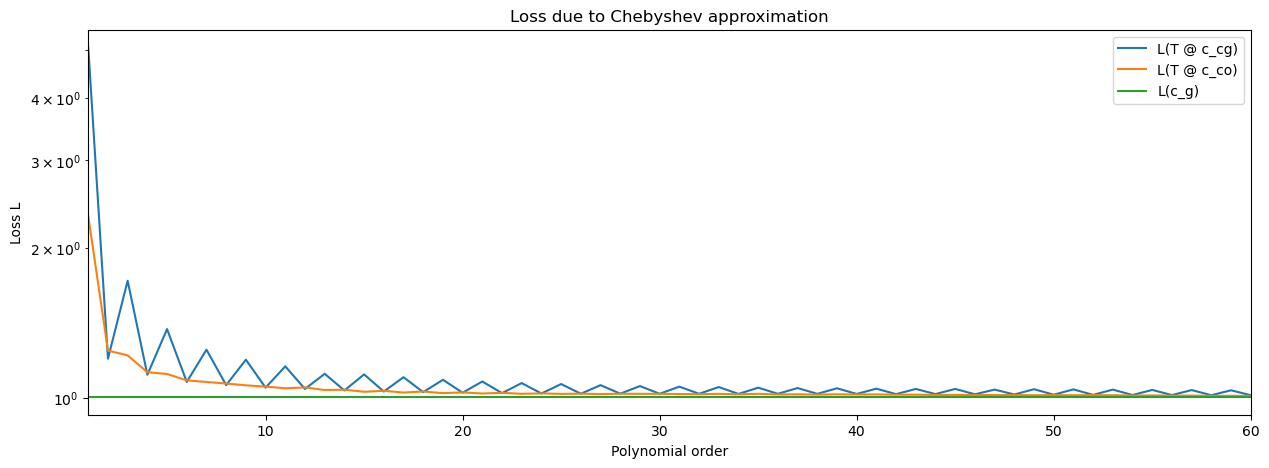

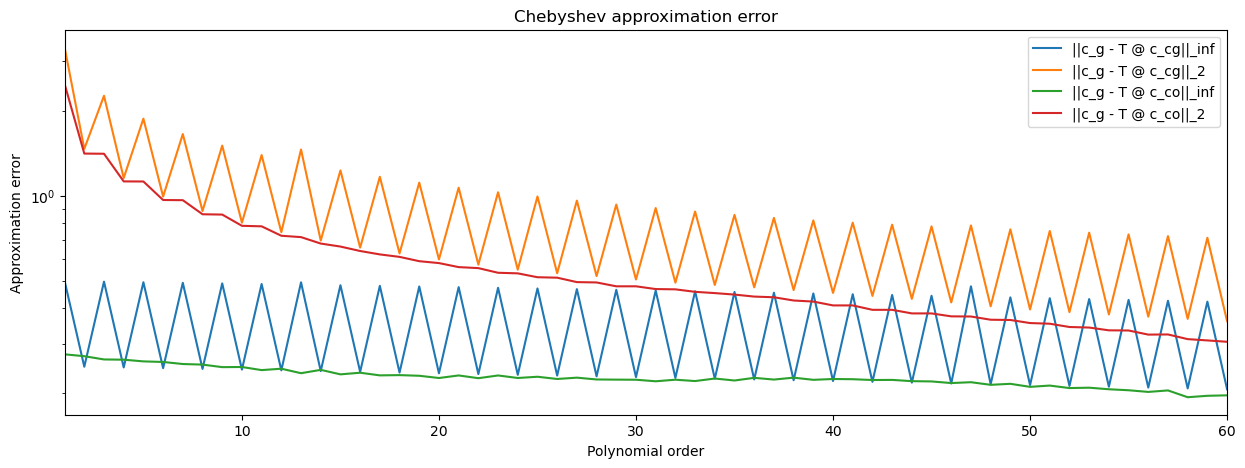

In [48]:
def polynomial_order(K):
    loss_cg = np.empty((K))
    loss_co = np.empty((K))
    approx_inf_cg = np.empty((K))
    approx_2_cg = np.empty((K))
    approx_inf_co = np.empty((K))
    approx_2_co = np.empty((K))
    
    kk = np.arange(1, K+1)
    for k in kk:
        T = cheby_basis(k, x)
        c_cg = cheby_coeff(k, f)
        loss_cg[k-1] = L(T @ c_cg)
        approx_inf_cg[k-1] = np.linalg.norm(c_g - T @ c_cg, ord=np.inf)
        approx_2_cg[k-1] = np.linalg.norm(c_g - T @ c_cg, ord=2)
        c_co = np.linalg.lstsq(T, f(x))[0]
        loss_co[k-1] = L(T @ c_co)
        approx_inf_co[k-1] = np.linalg.norm(c_g - T @ c_co, ord=np.inf)
        approx_2_co[k-1] = np.linalg.norm(c_g - T @ c_co, ord=2)
        
    fig_loss = plt.figure(figsize=(15,5))
    fig_approx = plt.figure(figsize=(15,5))
    ax_loss = fig_loss.add_subplot(1,1,1)
    ax_approx = fig_approx.add_subplot(1,1,1)
    
    ax_loss.semilogy(kk, loss_cg, label='L(T @ c_cg)')
    ax_loss.semilogy(kk, loss_co, label='L(T @ c_co)')
    ax_loss.semilogy(kk, L(c_g) * np.ones(K), label='L(c_g)')
    
    ax_approx.semilogy(kk, approx_inf_cg, label='||c_g - T @ c_cg||_inf')
    ax_approx.semilogy(kk, approx_2_cg, label='||c_g - T @ c_cg||_2')
    ax_approx.semilogy(kk, approx_inf_co, label='||c_g - T @ c_co||_inf')
    ax_approx.semilogy(kk, approx_2_co, label='||c_g - T @ c_co||_2')
    
    ax_loss.set_title('Loss due to Chebyshev approximation')
    ax_loss.set_ylabel('Loss L')
    ax_approx.set_title('Chebyshev approximation error')
    ax_approx.set_ylabel('Approximation error')
    for ax in ax_loss, ax_approx:
        ax.set_xlabel('Polynomial order')
        ax.set_xlim(1, K)
        ax.legend(loc='best')
        
    plt.show()
    
polynomial_order(60)

Choose the polynomial order $K$ and compute the basis $T$ with their associate coefficients `c_cg`.

In [49]:
K = 15
t_start = time.process_time()
c_cg = cheby_coeff(K, f)
T = cheby_basis(K, x)
print('Execution time: {:1.0f}ms'.format((time.process_time() - t_start) * 1000))

# If the order is sufficient for a perfect (as good as c_gt) reconstruction (test only).
pol_order_is_sufficient = False

Execution time: 1ms


### Loss function

* Independant coefficients: $L = \frac{1}{N} \sum_{i=1}^M \| (Tc)_i (U^T X)_{i,\cdot} - (U^T Y)_{i,\cdot} \|_2^2$.
* $L = \frac{1}{N} \| Tc \odot U^T X - U^T Y \|_2^2$.
* $\nabla_{c} L = \frac{2}{N} \left(T^T \left( U^T X \odot ( Tc \odot U^T X - U^T Y ) \right) \right) 1_N$.

In [50]:
def filter_chebyshev(X, c):
    """Filter X with the Chebyshev coefficients of the full filter."""
    return filter_full(X, T @ c)
c = np.zeros(K)
c[0] = 1
np.testing.assert_allclose(filter_chebyshev(X, c), X, atol=tol)

def Lc(c):
    M, N = X.shape
    return np.linalg.norm(filter_chebyshev(X, c) - Y, ord='fro')**2 / N
np.testing.assert_allclose(Lc(c_cg), L(T @ c_cg), atol=tol)
if pol_order_is_sufficient:
    np.testing.assert_allclose(Lc(c_cg), M * eps**2, rtol=1e-2, atol=tol)
    np.testing.assert_allclose(Lc(c_cg), L(c_g), atol=tol)

def dLc(X, Y, c):
    M, N = X.shape
    Xh = U.T @ X
    Yh = U.T @ Y
    return 2 / N * T.T @ (Xh * ((T @ c)[:,np.newaxis] * Xh - Yh)).sum(axis=1)
# Gradient should be null at the global minimum. With noise, c_cg is not necessary the optimum.
if eps <= 0 and pol_order_is_sufficient:
    np.testing.assert_allclose(dLc(X, Y, c_cg), 0, atol=tol)

### Optimality condition

* Given the signals $X$, $Y$ and the Chebyshev basis $T$, find the Chebyshev coefficients `c_co`.
* Optimality condition $\nabla_c L = 0$ gives $(U^T X \odot U^T X) 1_N \odot Tc = (U^T X \odot U^T Y) 1_N$.
* Why do we not always reach the minimum, i.e. $\nabla_c L = 0$ ? Probably an error in the gradient.

In [51]:
t_start = time.process_time()
c_co = np.linalg.lstsq(T, c_o)[0]
print('Execution time: {:1.0f}ms'.format((time.process_time() - t_start) * 1000))

assert Lc(c_co) < Lc(c_cg) + tol
assert np.linalg.norm(dLc(X, Y, c_co)) < np.linalg.norm(dLc(X, Y, c_cg))
#np.testing.assert_allclose(dLc(X, Y, c_co), 0, atol=tol)
if eps <= 0 and pol_order_is_sufficient:
    np.testing.assert_allclose(Lc(c_co), Lc(c_cg), atol=tol)

Execution time: 2ms


/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/1911858251.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_co = np.linalg.lstsq(T, c_o)[0]


### Stochastic gradient descent

* Why |dL(c)| does not converge to the null vector ? There should be no gradient at the optimum.
* Convergence seems harder than before.

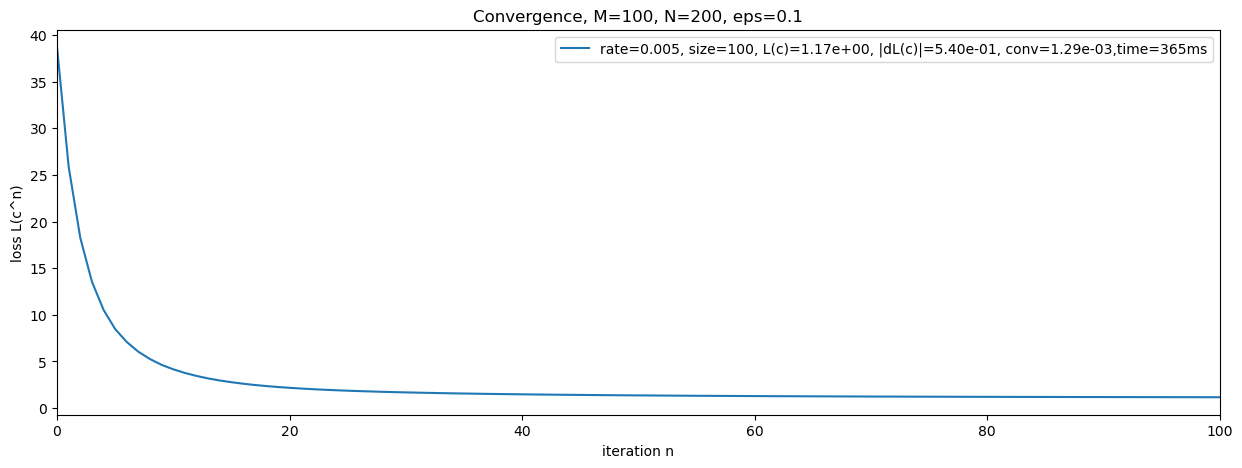

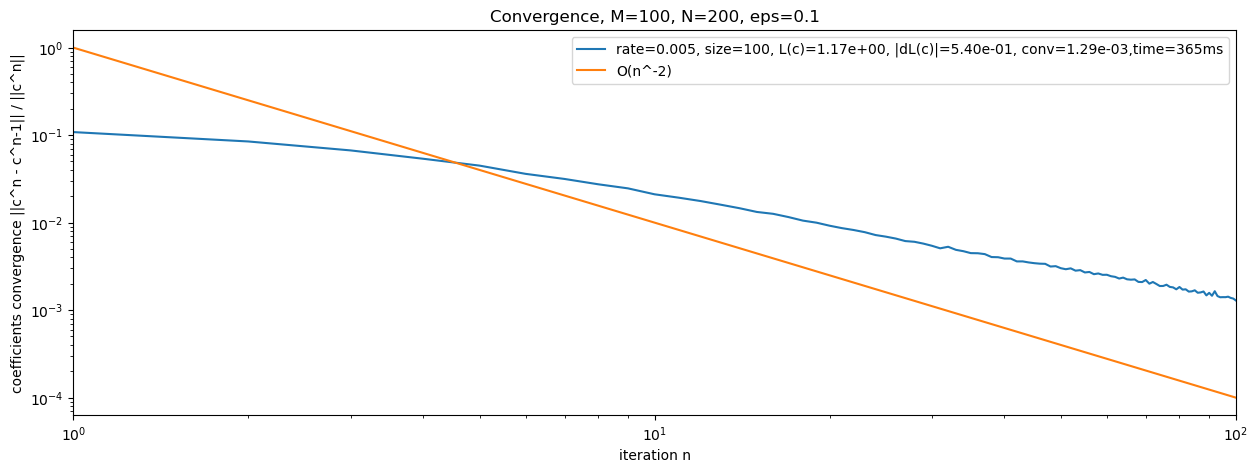

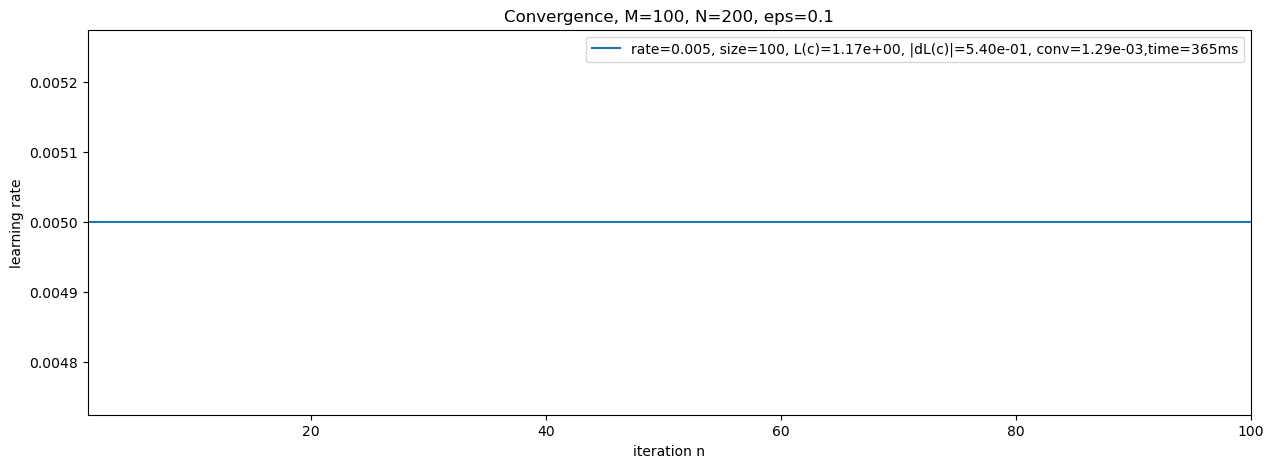

In [52]:
c0 = np.random.uniform(0, 1, K)
c_cs = sgd_plot_convergence(c0, Lc, dLc, [['0.005', 100]], crit=1e-3, maxit=100)[0]

### Results: learned filters

* The coefficients `c_co`, being optimal, alwas have a smallest loss than the ground truth `c_cg` (interpolant at the Chebyshev points).
* The SGD solution `c_cs` does not converge exactly to `c_co`.

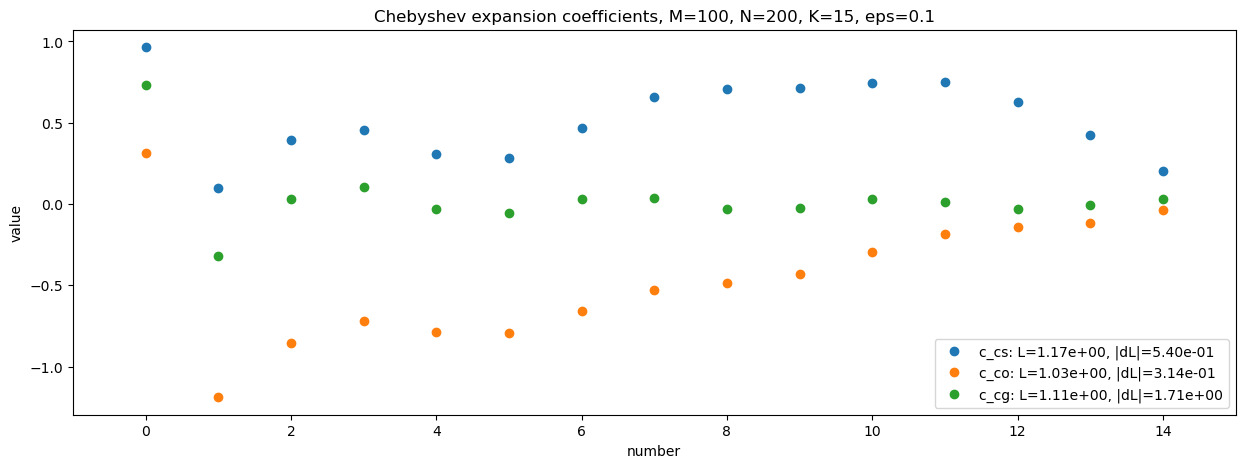

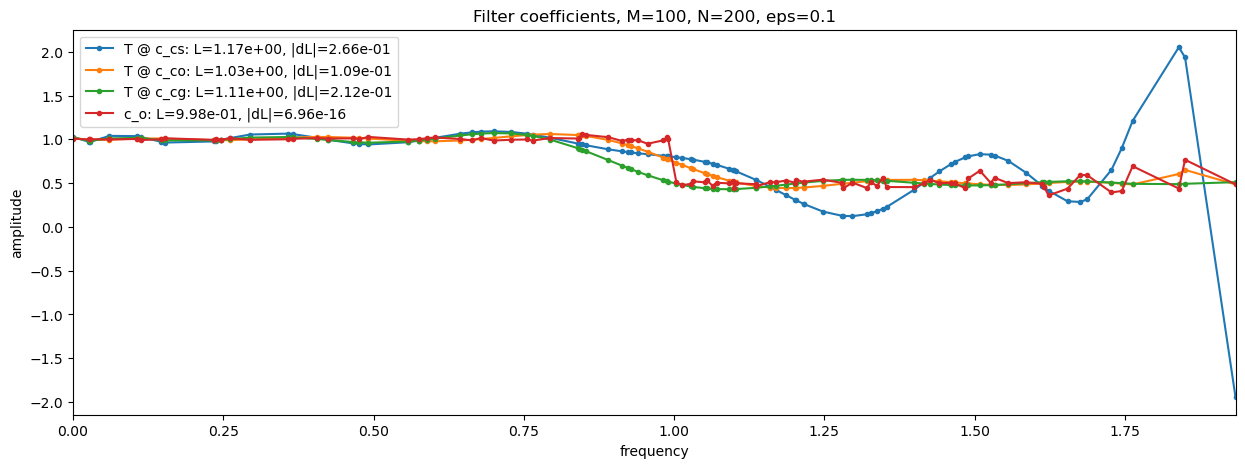

In [53]:
def plot_coefficients(coeffs):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,1,1)
    for coeff in coeffs:
        c = eval(coeff)
        label = '{}: L={:1.2e}, |dL|={:1.2e}'.format(coeff, Lc(c), np.linalg.norm(dLc(X,Y,c)))
        ax.plot(c, 'o', label=label)
#        np.testing.assert_allclose(np.linalg.norm(T @ c)**2, E, rtol=1e-2)
    ax.set_xlim(-1, K)
    ax.set_title('Chebyshev expansion coefficients, M={}, N={}, K={}, eps={}'.format(M, N, K, eps))
    ax.set_xlabel('number')
    ax.set_ylabel('value')
    ax.legend(loc='best')

plot_coefficients(['c_cs', 'c_co', 'c_cg'])
plot_filters(['T @ c_cs', 'T @ c_co', 'T @ c_cg', 'c_o'])

## Filter learning: recursive Chebyshev expansion as a function of the Laplacian

Compute (recursively) the Chebyshev polynomials $T_k$ as a function of the Laplacian $\mathcal{L}$ instead of the eigenvalues $\lambda$, thus avoiding the Fourier basis entirely.

* Cheaper $O(KMN)$ filtering operation. It avoids the $O(M^2N)$ multiplication by the Fourier basis $U$ to transform the signals in the spectral domain.
* Avoid the $O(M^3)$ EVD of the large (but sparse) Laplacian matrix needed to retrieve the Fourier basis. 
* Overall filtering complexity from $O(M^2 \max(M,N))$ to $O(KMN)$.

Notes:

* We need an estimate $\lambda_{max}$ of the Laplacian spectrum, i.e. an upper bound on the largest eigenvalue $\lambda_{M-1}$.
    * The normalized Laplacian spectrum is upper bounded by 2.
* We will need the adjoint for back-propagation.

### Chebyshev recursive formula

Step 1: Filter the signals $X$, given the Chebyshev coefficients $c$ of the filter.

* Multiply the signals by the Chebyshev polynomials: $\tilde{X}_k = T_k X$. This operation is indeed the filtering of the signals by the polynomials, unweigthed.
    * The trick here is that each $\tilde{X}_k$ is recursively generated from $\tilde{X}_{k-1}$ and $\tilde{X}_{k-2}$ with only a multiplication by the sparse Laplacian matrix $\mathcal{L}$.
    * This operation thus costs $O(K |E| N) = O(KMN)$ operations if the number of edges $|E|$ is proportional to the number of nodes $M$ (e.g. for kNN graphs) while transforming the signals into the Fourier domain costs $O(M^2N)$. It also avoids the need of the Fourier basis altogether, further saving $O(M^3)$ operations.
    * This is done once for all the signals. By keeping this intermediate result, filter coefficients $c$ can be applied efficiently multiple times during learning.
    * Memory: $\{\tilde{X}_k\} \in \mathbb{R}^{K \times M \times N}$.
* The filtered signals are then given by $\sum_k c_k \tilde{X}_k$.
    * This operation requires $O(KMN)$ operations where filtering in the Fourier domain costs $O(MN)$. There will be many of these operations during SGD.

In [54]:
def rescale_L(L):
    """Rescale the Laplacian eigenvalues in [-1,1]."""
    M, M = L.shape
    I = scipy.sparse.identity(M, format='csr')
    return L / lmax * 2 - I
    
def cheby_basis_eval(L, X, K):
    """Return T_k X where T_k are the Chebyshev polynomials of order up to K.
    Complexity is O(KMN)."""
    M, N = X.shape
    L = rescale_L(L)
    # Xt = T @ X: MxM @ MxN.
    Xt = np.empty((K, M, N))
    # Xt_0 = T_0 X = I X = X.
    Xt[0,...] = X
    # Xt_1 = T_1 X = L X.
    if K > 1:
        Xt[1,...] = L.dot(X)
    # Xt_k = 2 L Xt_k-1 - Xt_k-2.
    for k in range(2, K):
        Xt[k,...] = 2 * L.dot(Xt[k-1,...]) - Xt[k-2,...]
    return Xt
np.testing.assert_allclose(cheby_basis_eval(LL, X, 1)[0,...], X)

def filter_basis(Xt, c):
    K, M, N = Xt.shape
    Y = c @ Xt.reshape((K, M*N))
    Y.shape = (M, N)
    return Y

### Clenshaw's method

* An algorithm which can evaluate any 3-relations recusive polynomial given the coefficients.
* The complexity of filtering with Clenshaw is $O(KMN)$, exactly the same as the standard Chebyshev recursion.
* The advantage of Chebyshev recursion is the possibility to store the $\tilde{X}_k$, which diminishes the computational cost by two for successive evaluation with different coefficients.
* Is the approximation error of this method smaller ? Otherwise I don't see why numerical packages like scipy use it.

In [55]:
def eval_clenshaw(x, c):
    K = len(c)
    b2 = 0
    b1 = c[K-1] * np.ones(x.shape) if K >= 2 else 0
    for k in range(K-2, 0, -1):
        b = c[k] + 2 * x * b1 - b2
        b2, b1 = b1, b
    return c[0] + x * b1 - b2

def test(K, N=100):
    x = np.linspace(-1, 1, N)
    T = np.empty((N, K))
    for k in range(K):
        c = np.zeros(k+1)
        c[k] = 1
        T[:,k] = eval_clenshaw(x, c)
    np.testing.assert_allclose(T, cheby_basis(K, x))
test(50)

def filter_clenshaw(L, X, c):
    K = len(c)
    L = rescale_L(L)
    B2 = 0
    B1 = c[K-1] * X if K >= 2 else np.zeros(X.shape)
    for k in range(K-2, 0, -1):
        B = c[k] * X + 2 * L.dot(B1) - B2
        B2, B1 = B1, B
    return c[0] * X + L.dot(B1) - B2

### Testing polynomials evaluation and filtering

* Filtering in Fourier seems faster because the Laplacian is already diagonalized.
* Clenshaw is faster for one-shot filtering because we don't keep the intermediate result.

In [56]:
def test(c):
    t_start = time.process_time()
    T = cheby_basis(len(c), x)
    Y1 = filter_full(X, T @ c)
    t_full = (time.process_time() - t_start) * 1000
    
    t_start = time.process_time()
    Xt = cheby_basis_eval(LL, X, len(c))
    Y2 = filter_basis(Xt, c)
    t_cheby = (time.process_time() - t_start) * 1000
    np.testing.assert_allclose(Y1, Y2, atol=tol)
    
    t_start = time.process_time()
    Y2 = filter_clenshaw(LL, X, c)
    t_clenshaw = (time.process_time() - t_start) * 1000
    np.testing.assert_allclose(Y1, Y2, atol=tol)
    
    print('Execution times: {:1.0f}ms {:1.0f}ms {:1.0f}ms'.format(t_full, t_cheby, t_clenshaw))

test(np.array([1]))
test(np.array([1,0,0,0]))
test(np.array([0,1,0,0]))
test(np.array([0,0,1,0]))
test(np.array([0,0,0,1]))
test(np.random.uniform(0, 5, size=100))
test(c_cg)
test(c_co)

Execution times: 28ms 3ms 5ms
Execution times: 3ms 2ms 2ms
Execution times: 2ms 3ms 4ms
Execution times: 2ms 5ms 7ms
Execution times: 2ms 5ms 2ms
Execution times: 6ms 59ms 41ms
Execution times: 2ms 14ms 7ms
Execution times: 2ms 5ms 5ms


### Loss function and optimality condition

Step 2: Find the coefficients $c_k$ by minimizing $L = \frac{1}{N} \|\tilde{X} - Y\|_F^2$ where $\tilde{X} = \sum_k c_k \tilde{X}_k$ are the filtered signals.

* Rewrite as $L = \frac{1}{N} \|\bar{X} c - \bar{y}\|_2^2$ where $\bar{y}$ is the vectorized matrix $Y$ and the $k^\text{th}$ column of $\bar{X}$ is the vectorized matrix $\tilde{X}_k$.
* Gradient $\nabla_c L = \frac{2}{N} \bar{X}^T (\bar{X} c - \bar{y})$.
* Optimality condition $\bar{X} c = \bar{y}$.
    * Largely over-determined as $K << MN$; $\bar{y} \in \mathbb{R}^{NM}$ and $c \in \mathbb{R}^K$.

In [57]:
def vectorize(Xt, Y):
    K, M, N = Xt.shape
    return Xt.reshape((K, M*N)), Y.reshape((M*N))

def Lcr(c):
    Xt = cheby_basis_eval(LL, X, len(c))
    return np.linalg.norm(filter_basis(Xt, c) - Y, ord='fro')**2 / N

def dLcr(X, Y, c):
    Xt = cheby_basis_eval(LL, X, len(c))
    Xb, yb = vectorize(Xt, Y)
    return 2 / N * (c @ Xb - yb) @ Xb.T

def basis_coeff_opt(basis_eval, X, Y, K):
    Xt = basis_eval(LL, X, K)
    Xb, yb = vectorize(Xt, Y)
    return np.linalg.lstsq(Xb.T, yb)[0]

t_start = time.process_time()
c_cro = basis_coeff_opt(cheby_basis_eval, X, Y, K)
print('Execution time: {:1.0f}ms'.format((time.process_time() - t_start) * 1000))

np.testing.assert_allclose(Lcr(c_cro), L(T @ c_cro), atol=tol)
assert Lcr(c_cro) < Lcr(c_cg) + tol
assert Lcr(c_cro) < Lcr(c_co) + tol
if pol_order_is_sufficient:
    np.testing.assert_allclose(Lcr(c_cro), M * eps**2, rtol=2e-2, atol=tol)
if eps <= 0 and pol_order_is_sufficient:
    np.testing.assert_allclose(Lcr(c_cro), Lcr(c_co), atol=tol)
np.testing.assert_allclose(dLcr(X, Y, c_cro), 0, atol=1e-8)
assert np.linalg.norm(dLcr(X, Y, c_cro)) < np.linalg.norm(dLcr(X, Y, c_cg)) + tol
assert np.linalg.norm(dLcr(X, Y, c_cro)) < np.linalg.norm(dLcr(X, Y, c_co)) + tol

Execution time: 26ms


/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/61385885.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(Xb.T, yb)[0]


* A direct solution is available trough the computation of the pseudo-inverse.
* This method is however instable for large $K$.

In [58]:
def cheby_coeff_direct(X, Y, K, svd=False):
    Xt = cheby_basis_eval(LL, X, K)
    Xb, yb = vectorize(Xt, Y)
    if svd:
        Xpinv = np.linalg.pinv(Xb.T)
    else:
        A = Xb @ Xb.T
        Ainv = np.linalg.inv(A)
        #np.testing.assert_allclose(Ainv @ A, np.identity(K), atol=1e-5)
        Xpinv = Ainv @ Xb
    #np.testing.assert_allclose(Xpinva, Xpinv, atol=tol)
    return Xpinv @ yb
c_crd = cheby_coeff_direct(X, Y, K)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Stochastic gradient descent

* The learning rate does not have much influence on the convergence, as long as it is small enough. A constant learning rate is sufficient.

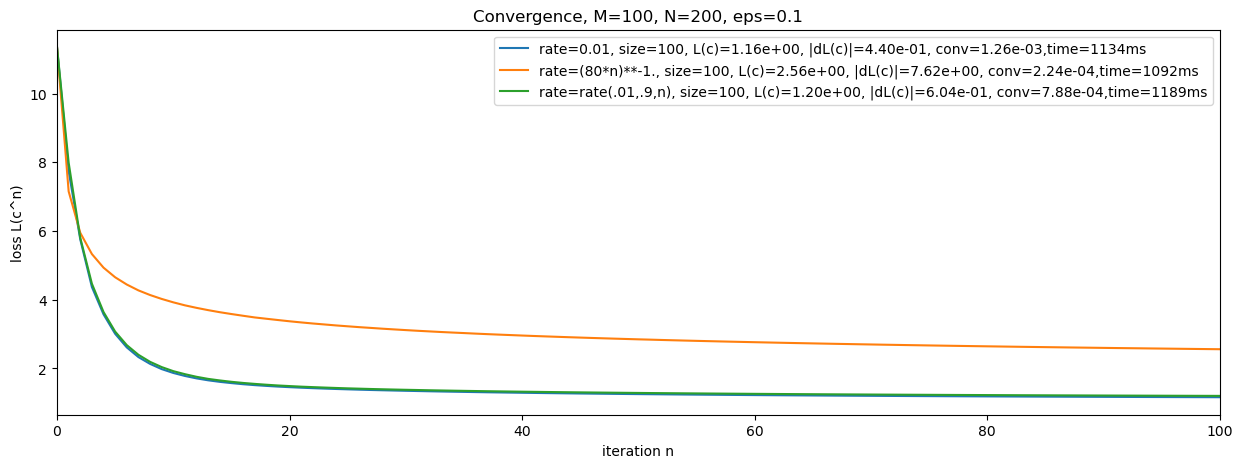

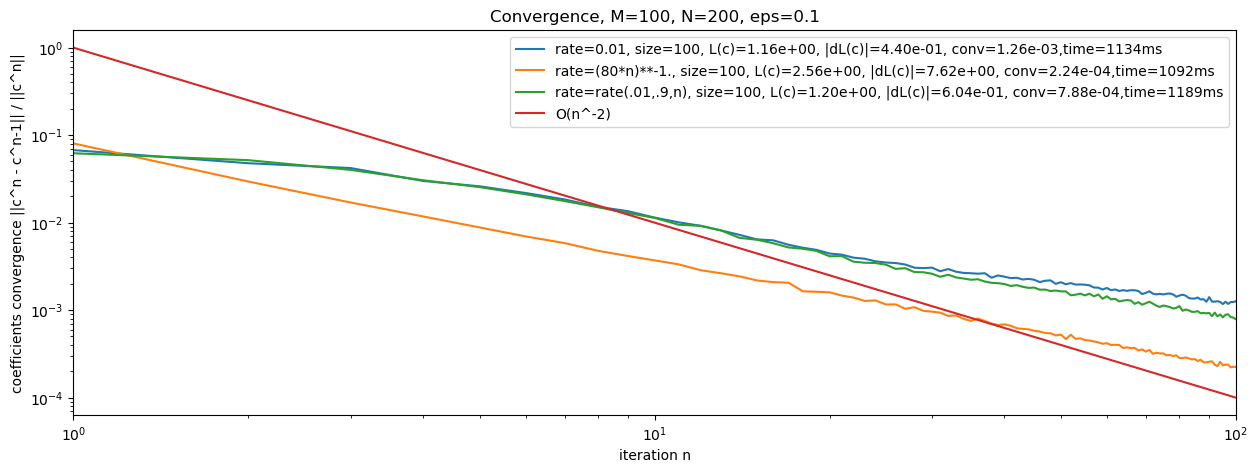

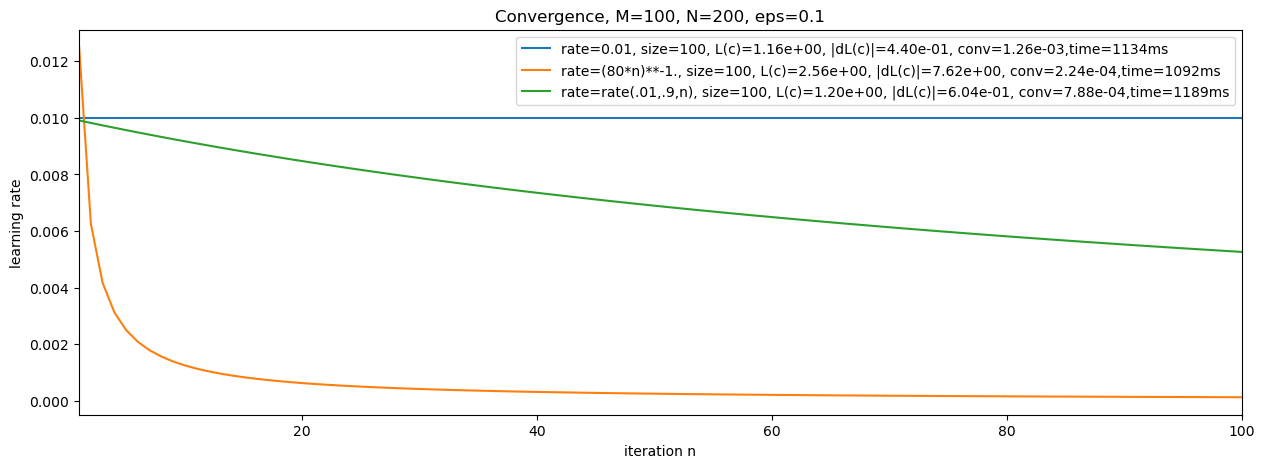

In [59]:
params = []
params.append(['0.01', 100])
params.append(['(80*n)**-1.', 100])
params.append(['rate(.01,.9,n)', 100])
c0 = np.random.uniform(0, 1, K)
c_crs = sgd_plot_convergence(c0, Lcr, dLcr, params, crit=1e-3, maxit=100)[0]

### Results: learned filters

* The optimal solutions `c_co` and `c_cro` are close and have the smallest loss.
* The SGD solutions `c_cs` and `c_crs` are close while a bit less accurate.
    * Probably the convergence isn't that great.
    * They approximate the hight frequencies the least accurately.
* The ground truth solution lies in the middle.

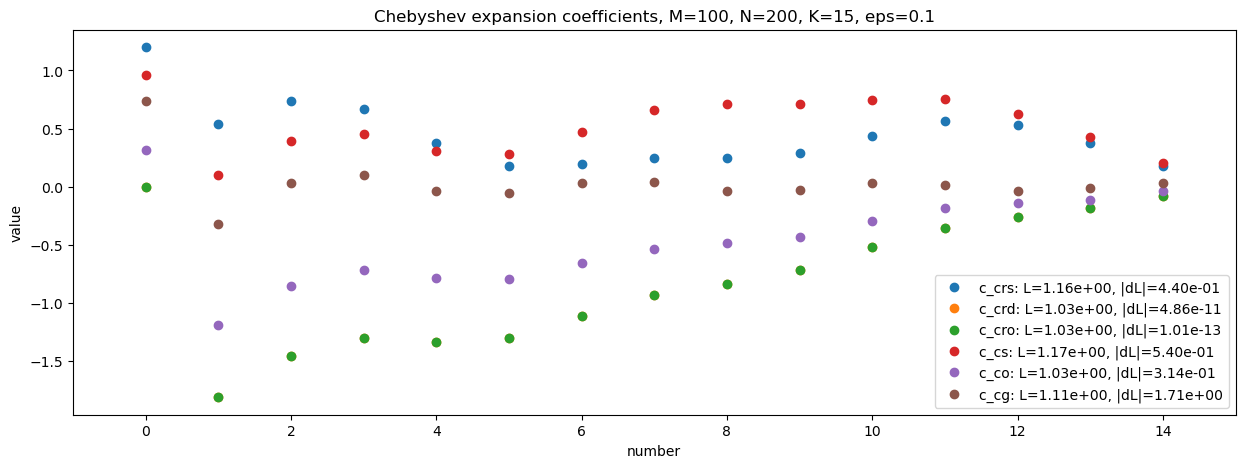

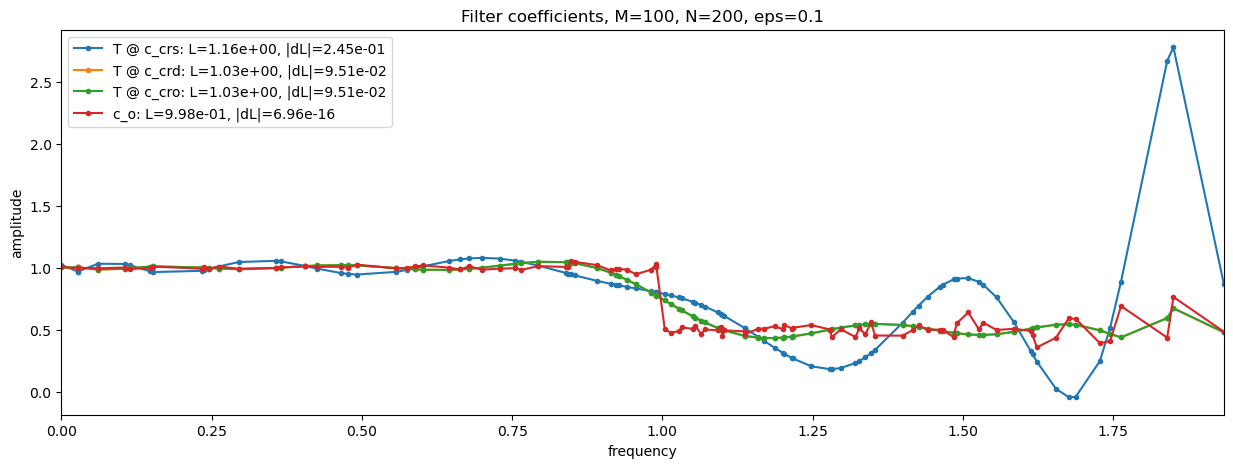

In [60]:
plot_coefficients(['c_crs', 'c_crd', 'c_cro', 'c_cs', 'c_co', 'c_cg'])
plot_filters(['T @ c_crs', 'T @ c_crd', 'T @ c_cro', 'c_o'])

## Filter learning: Lanczos method

The Lanczos method generates an orthonormal basis for the Kyrlov subspace $\mathcal{K}_K(\mathcal{L}, x) = \operatorname{span}\{x, \mathcal{L}x, \mathcal{L}^2x, \ldots, \mathcal{L}^{K-1}x \}$.

In [61]:
def lanczos(L, X, K):
    M, N = X.shape
    a = np.empty((K, N))
    b = np.zeros((K, N))
    V = np.empty((K, M, N))
    V[0,...] = X / np.linalg.norm(X, axis=0)
    for k in range(K-1):
        W = L.dot(V[k,...])
        a[k,:] = np.sum(W * V[k,...], axis=0)
        W = W - a[k,:] * V[k,...] - (b[k,:] * V[k-1,...] if k>0 else 0)
        b[k+1,:] = np.linalg.norm(W, axis=0)
        V[k+1,...] = W / b[k+1,:]
    a[K-1,:] = np.sum(L.dot(V[K-1,...]) * V[K-1,...], axis=0)
    return V, a, b

def lanczos_H_diag(a, b, impl=5):
    K, N = a.shape
    H = np.empty((K, K, N))
    Q = np.empty((K, K, N))
    Sigma = np.empty((K, N))
    
    if impl is 1:
        for n in range(N):
            H[...,n] = np.diag(a[:,n]) + np.diag(b[1:,n], +1) + np.diag(b[1:,n], -1)
            #H[...,n] = V[...,n] @ LL.dot(V[...,n].T)
            #Sigma[:,n], Q[...,n] = np.linalg.eig(H[...,n])
            Sigma[:,n], Q[...,n] = np.linalg.eigh(H[...,n])
    
    elif impl is 2:
        for n in range(N):
            H[...,n] = np.diag(a[:,n]) + np.diag(b[1:,n], -1)
            Sigma[:,n], Q[...,n] = np.linalg.eigh(H[...,n], UPLO='L')
    
    elif impl is 3:
        for n in range(N):
            H[...,n] = np.diag(a[:,n]) + np.diag(b[1:,n], +1) + np.diag(b[1:,n], -1)
        Sigma, Q = np.linalg.eigh(H.T)
        Q = np.swapaxes(Q,1,2).T
        Sigma = Sigma.T
    
    elif impl is 4:
        for n in range(N):
            H[...,n] = np.diag(a[:,n]) + np.diag(b[1:,n], +1)
        Sigma, Q = np.linalg.eigh(H.T, UPLO='L')
        Q = np.swapaxes(Q,1,2).T
        Sigma = Sigma.T
    
    elif impl is 5:
        H = np.zeros((K*K, N))
        H[:K**2:K+1, :] = a
        H[1:(K-1)*K:K+1, :] = b[1:,:]
        H.shape = (K, K, N)
        Sigma, Q = np.linalg.eigh(H.T, UPLO='L')
        Q = np.swapaxes(Q,1,2).T
        Sigma = Sigma.T
        
    elif impl is 6:
        H = np.zeros((K, K, N))
        h = np.diagonal(H, 0, 0, 1)
        h.setflags(write=True)
        h[:] = a.T
        h = np.diagonal(H, 1, 0, 1)
        h.setflags(write=True)
        h[:] = b[1:,:].T
        Sigma, Q = np.linalg.eigh(H.T, UPLO='L')
        Q = np.swapaxes(Q,1,2).T
        Sigma = Sigma.T
    
    elif impl is 7:
        H_band = np.empty((2, K, N))
        H_band[0,...] = b
        H_band[1,...] = a
        for n in range(N):
            Sigma[:,n], Q[...,n] = scipy.linalg.eig_banded(H_band[...,n])
    
    return H, Q, Sigma

def test():
    V, a, b = lanczos(LL, X, K)
    H, Q, Sigma = lanczos_H_diag(a, b, impl=1)
    
    for impl in range(1, 8):
        tstart = time.process_time()
        h, q, sigma = lanczos_H_diag(a, b, impl)
        t = (time.process_time() - tstart) * 1000
        print('Implementation {}: {:.2f} ms'.format(impl, t))
        np.testing.assert_allclose(sigma, Sigma)
        np.testing.assert_allclose(q, Q)

    # Spectrum is preserved.
    assert np.all(Sigma > -tol)
    assert np.all(Sigma < lmax -tol)
    
    # Orthonormal bases V and Q.
    def test_orthonormality(A):
        K, _, N = A.shape
        A = A.reshape(K, -1)
        np.testing.assert_allclose(A @ A.T, N * np.identity(K), atol=1e-6)
    test_orthonormality(V)
    test_orthonormality(Q)

    # Verify H = Q Sigma Q.T
    Hh = np.empty((K, K, N))
    for n in range(N):
        Hh[...,n] = Q[...,n] @ np.diag(Sigma[:,n]) @ Q[...,n].T
    np.testing.assert_allclose(Hh, H, atol=tol)

    # Verify L approx V H V.T
    err = 0
    for n in range(N):
        Lh = V[...,n].T @ H[...,n] @ V[...,n]
        err += np.linalg.norm(LL - Lh) / scipy.sparse.linalg.norm(LL)
    print('Laplacian approximation error: {}'.format(err / N))
    
    # Verify H = V L V.T
    for n in range(N):
        np.testing.assert_allclose(V[...,n] @ LL.dot(V[...,n].T), H[...,n], atol=1e-5)

    # Test the Lanczos coefficients for a linear LL.dot(x).
    for n in range(N):
        y = LL.dot(X[:,n])
        e1 = np.zeros(K)
        e1[0] = 1
        c_lg = np.linalg.norm(X[:,n]) * H[...,n] @ e1
        c_lo = np.linalg.lstsq(V[...,n].T, y)[0]
        np.testing.assert_allclose(c_lo, c_lg, atol=tol)
        np.testing.assert_allclose(c_lg @ V[...,n], LL.dot(X[:,n]), atol=tol)
test()

Implementation 1: 5.06 ms
Implementation 2: 4.58 ms
Implementation 3: 3.67 ms
Implementation 4: 3.40 ms
Implementation 5: 2.54 ms
Implementation 6: 2.50 ms
Implementation 7: 4.36 ms
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Laplacian approximation error: 0.9199812221662558


<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:48: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:41: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:48: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/2018609812.py:22: SyntaxWarning: "is" with a literal. Did you mean "

### Lanczos basis method

* Very similar to the full filter:
    1. Transformation of the vertex signals into another basis (Lanczos, Fourier).
    2. Filtering in the alternative basis.

In [62]:
def lanczos_basis_eval_f(L, X, K):
    V, a, b = lanczos(L, X, K)
    H, Q, Sigma = lanczos_H_diag(a, b)
    return V, Q

def lanczos_representation_f(X, Y, K, impl=2):
    V, Q = lanczos_basis_eval_f(LL, X, K)
    if impl is 1:
        Xh = np.empty((K, N))
        Yh = np.empty((K, N))
        for n in range(N):
            Xh[:,n] = Q[...,n].T @ V[...,n] @ X[:,n]
            Yh[:,n] = Q[...,n].T @ V[...,n] @ Y[:,n]
    elif impl is 2:
        Xh = np.empty((K, N))
        Yh = np.empty((K, N))
        for n in range(N):
            QV = Q[...,n].T @ V[...,n]
            Xh[:,n] = QV @ X[:,n]
            Yh[:,n] = QV @ Y[:,n]
    elif impl is 3:
        QV = np.empty((K, M, N))
        for n in range(N):
            QV[...,n] = Q[...,n].T @ V[...,n]
        Xh = np.einsum('ijl,jl->il', QV, X)
        Yh = np.einsum('ijl,jl->il', QV, Y)
    elif impl is 4:
        QV = np.einsum('ijl,ikl->jkl', Q, V)
        Xh = np.einsum('ijl,jl->il', QV, X)
        Yh = np.einsum('ijl,jl->il', QV, Y)
    return Xh, Yh

def test():
    Xh, Yh = lanczos_representation_f(X, Y, K, impl=1)
    for impl in range(1, 5):
        tstart = time.process_time()
        xh, yh = lanczos_representation_f(X, Y, K, impl=impl)
        t = (time.process_time() - tstart) * 1000
        print('Implementation {}: {:.2f} ms'.format(impl, t))
        np.testing.assert_allclose(xh, Xh)
        np.testing.assert_allclose(yh, Yh)
test()

def lanczos_coeff_direct_f(X, Y, K, impl=2):
    Xh, Yh = lanczos_representation_f(X, Y, K)
    return (Xh * Yh).sum(axis=1) / (Xh * Xh).sum(axis=1)

def filter_lanczos_f(X, c):
    V, Q = lanczos_basis_eval_f(LL, X, len(c))
    Y = np.empty((M, N))
    for n in range(N):
        QV = Q[...,n].T @ V[...,n]
        Y[:,n] = QV.T @ np.diag(c) @ QV @ X[:,n]
    return Y

def Lc_f(c):
    return np.linalg.norm(filter_lanczos_f(X, c) - Y, ord='fro')**2 / N

def dLc_f(X, Y, c):
    M, N = X.shape
    Xh, Yh = lanczos_representation_f(X, Y, K)
    return 2 / N * ((c[:,np.newaxis] * Xh - Yh) * Xh).sum(axis=1)

c_lf = lanczos_coeff_direct_f(X, Y, K)
np.testing.assert_allclose(dLc_f(X, Y, c_lf), 0, atol=tol)

<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/3045576950.py:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if impl is 1:
/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/3045576950.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif impl is 2:
/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/3045576950.py:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif impl is 3:
/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000

Implementation 1: 43.43 ms
Implementation 2: 39.47 ms
Implementation 3: 54.36 ms
Implementation 4: 77.56 ms


### Fast Lanczos method

* As it is a basis, it is very similar to Chebyshev.
* As the basis is orthogonal, each coefficient is independent and can solved for independantly (thus in parallel).
* Thanks to the orthogonality, a direct solution is available without the need of a pseudo-inverse. It is just the "mean" projection onto the basis vectors.

In [63]:
def lanczos_basis_eval(L, X, K, ret_q=False, impl=2):
    V, a, b = lanczos(L, X, K)
    H, Q, Sigma = lanczos_H_diag(a, b)
    M, N = X.shape
    
    if impl is 1:
        Xt = np.empty((K, M, N))
        for n in range(N):
            Xt[...,n] = np.linalg.norm(X[:,n]) * np.diag(Q[0,:,n]) @ Q[...,n].T @ V[...,n]
            #Xt[...,n] = np.linalg.norm(X[:,n]) * Q[...,n].T @ V[...,n]
            #Xt[...,n] = np.linalg.norm(X[:,n]) * V[...,n]
    
    # This is the fastest.
    elif impl is 2:
        Xt = np.empty((K, M, N))
        for n in range(N):
            Xt[...,n] = Q[...,n].T @ V[...,n]
        Xt *= Q[0,:,np.newaxis,:]
        Xt *= np.linalg.norm(X, axis=0)
    
    # Too bad that einsum is so slow...
    elif impl is 3:
        Xt = np.einsum('ijl,ikl->jkl', Q, V)
        Xt *= Q[0,:,np.newaxis,:]
        Xt *= np.linalg.norm(X, axis=0)
    
    if ret_q:
        return Xt, Q
    else:
        return Xt

def test():
    Xt = lanczos_basis_eval(LL, X, K, impl=1)
    for impl in range(1, 4):
        tstart = time.process_time()
        xt = lanczos_basis_eval(LL, X, K, impl=impl)
        t = (time.process_time() - tstart) * 1000
        print('Implementation {}: {:.2f} ms'.format(impl, t))
        np.testing.assert_allclose(xt, Xt)
test()

def lanczos_coeff_direct(X, Y, K):
    Xt, Q = lanczos_basis_eval(LL, X, K, True)
    Xb, yb = vectorize(Xt, Y)
    return Xb @ yb / np.sum((np.linalg.norm(X, axis=0) * Q[0,...])**2, axis=1)
    #return Xb @ yb / np.linalg.norm(X, ord='fro')**2
    #return Xb @ yb / N

def Lc(c):
    Xt = lanczos_basis_eval(LL, X, len(c))
    return np.linalg.norm(filter_basis(Xt, c) - Y, ord='fro')**2 / N

def dLc(X, Y, c):
    Xt = lanczos_basis_eval(LL, X, len(c))
    Xb, yb = vectorize(Xt, Y)
    return 2 / N * (c @ Xb - yb) @ Xb.T

c_ld = lanczos_coeff_direct(X, Y, K)
np.testing.assert_allclose(c_ld, c_lf, atol=tol)
np.testing.assert_allclose(dLc(X, Y, c_ld), 0, atol=tol)

c_lo = basis_coeff_opt(lanczos_basis_eval, X, Y, K)
np.testing.assert_allclose(c_lo, c_lf, atol=tol)
np.testing.assert_allclose(dLc(X, Y, c_lo), 0, atol=tol)

print('Coefficients energy E = {}'.format(np.linalg.norm(c_lo)**2))

def test():
    c = np.random.uniform(0, 1, K)
    np.testing.assert_allclose(Lc_f(c), Lc(c))
    np.testing.assert_allclose(dLc_f(X, Y, c), dLc(X, Y, c))

Implementation 1: 39.92 ms
Implementation 2: 47.33 ms
Implementation 3: 70.47 ms
Coefficients energy E = 9.98488688528191


<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/3875251074.py:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if impl is 1:
/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/3875251074.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif impl is 2:
/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/3875251074.py:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif impl is 3:
/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/61385885.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times `

### Stochastic gradient descent

* Convergence is much faster because the Lanczos basis is orthonormal.
* It converges to the optimal solution.

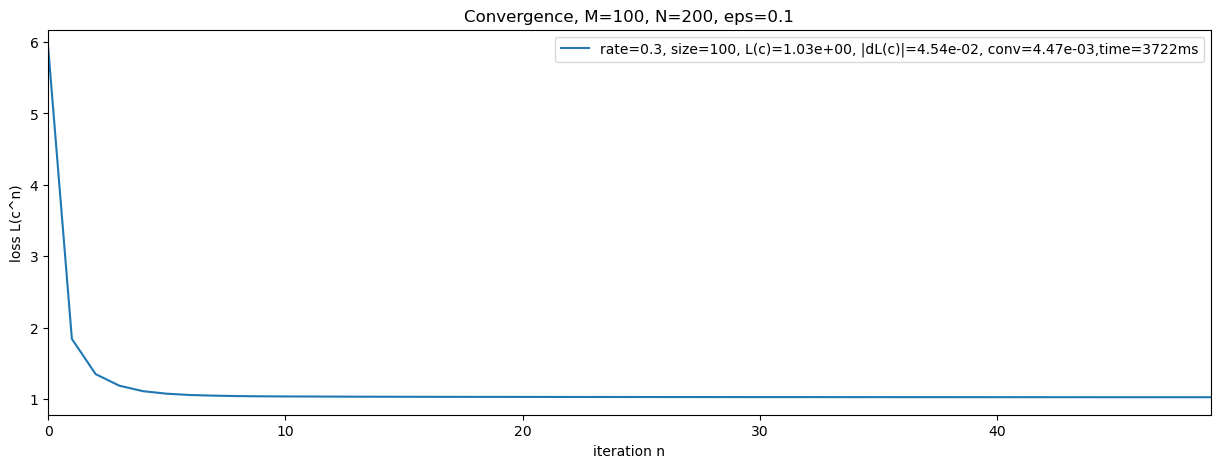

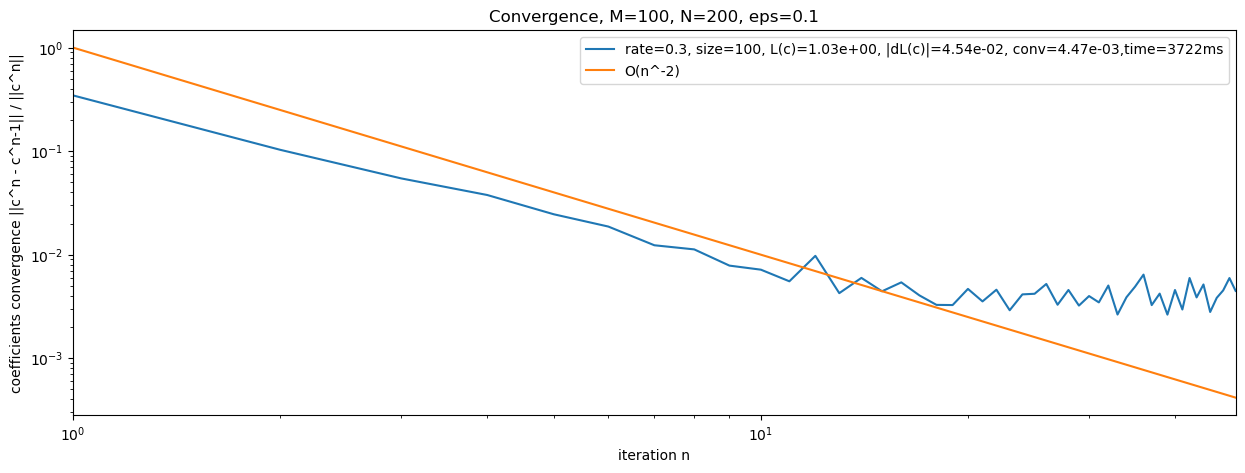

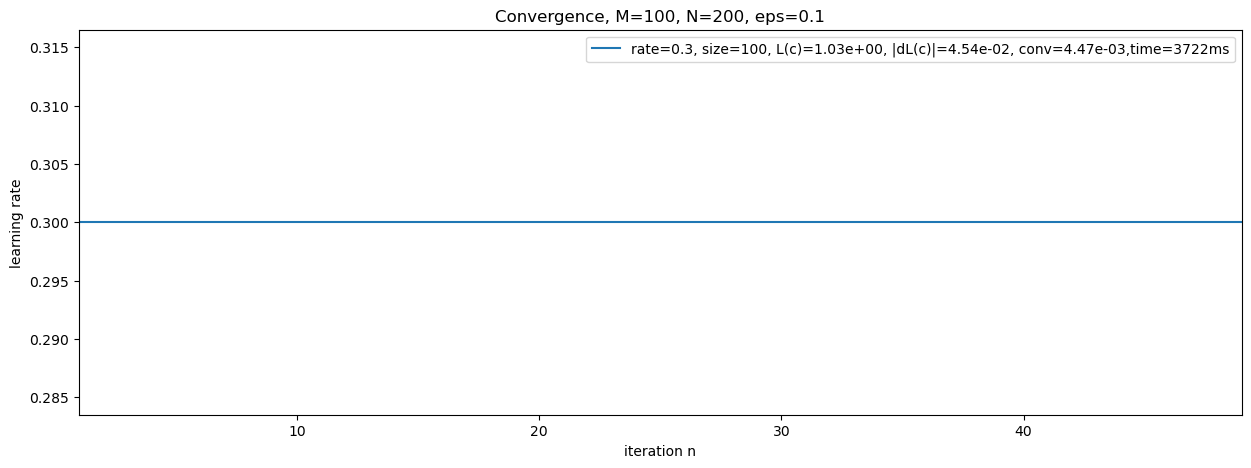

In [64]:
c0 = np.random.uniform(0, 1, K)
c_ls = sgd_plot_convergence(c0, Lc, dLc, [['0.3', 100]], crit=1e-3, maxit=100)[0]

### Results

* Convergence with SGD is much easier for Lanczos than Chebyshev, because of the orthogonal basis.

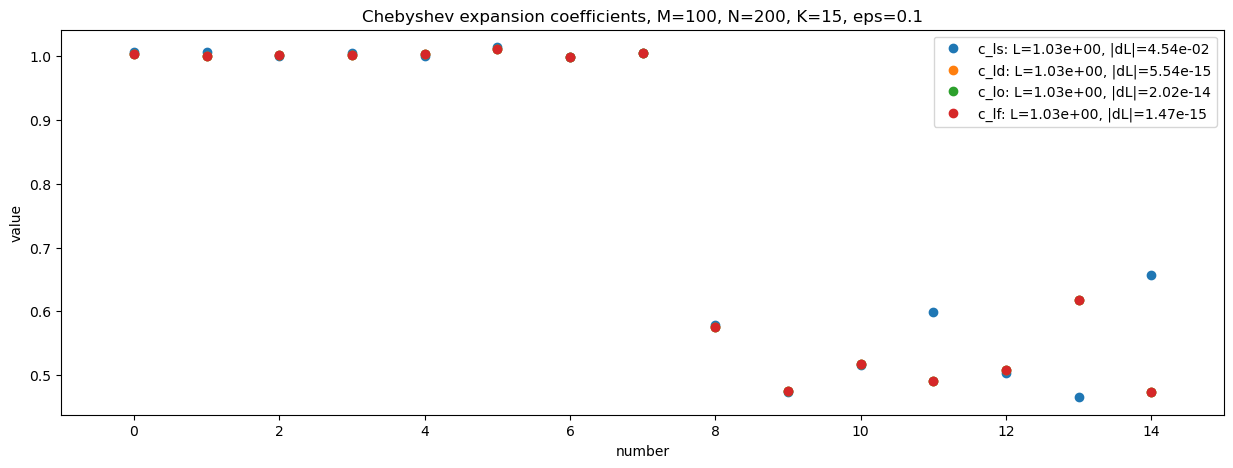

In [65]:
plot_coefficients(['c_ls', 'c_ld', 'c_lo', 'c_lf'])

* The optimal spectral filter `c_o` has different optimal representations in the Lanczos bases, depending on the signal.
* The filter in the spectral domain is different for each signal.
* The DC part seems to be the most disparate.

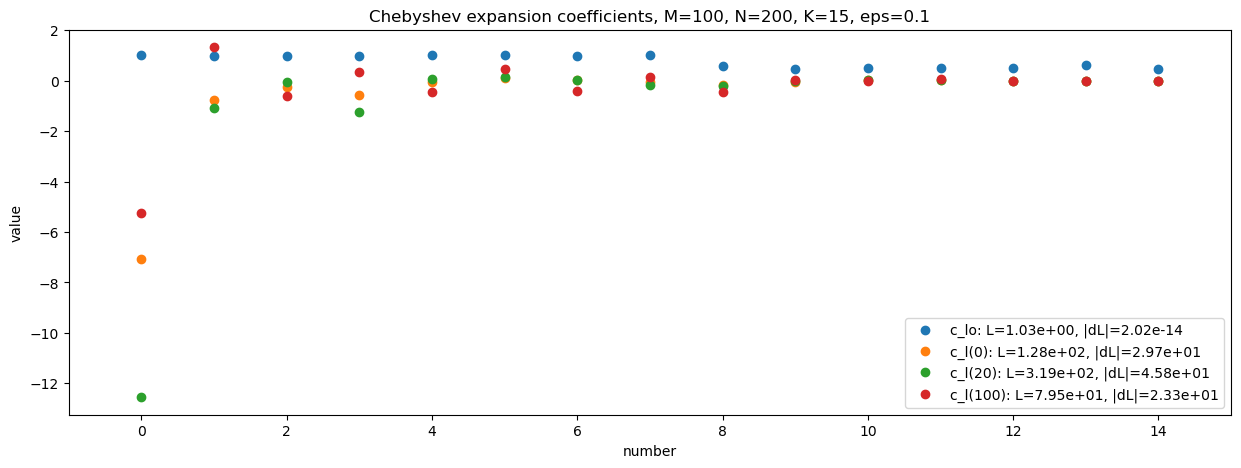

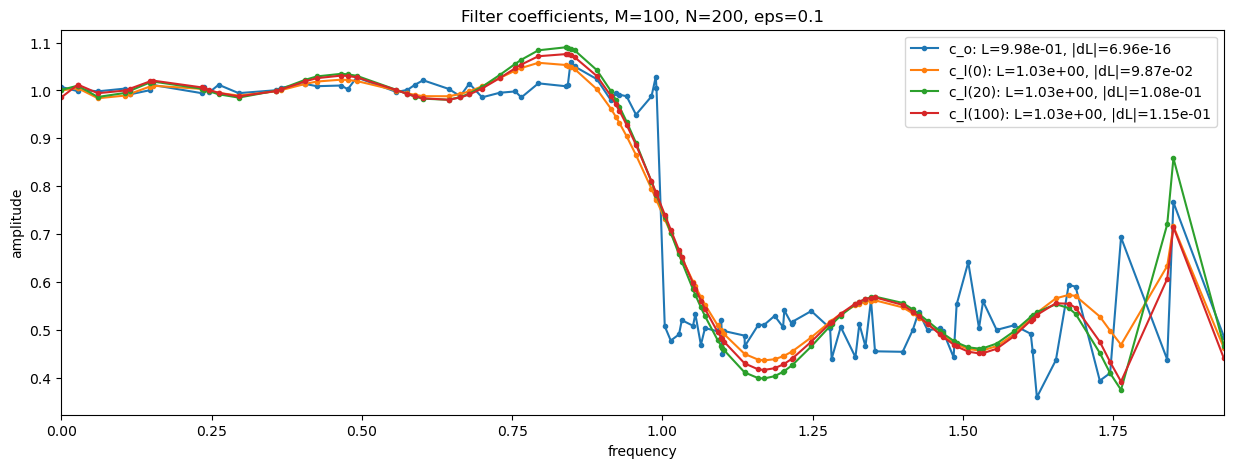

In [66]:
def c_l(n):
    Xt = lanczos_basis_eval(LL, X, K)
    return Xt[...,n] @ c_o
plot_coefficients(['c_lo', 'c_l(0)', 'c_l(20)', 'c_l(100)'])

def c_l(n):
    x = X[:,n:n+1]
    Xt = lanczos_basis_eval(LL, x, K)
    yh = U.T @ filter_basis(Xt, c_lo)
    xh = U.T @ x
    return (yh / xh).squeeze()
    return (U.T @ (c_lo @ V[...,n])) / (U.T @ X[:,n])
plot_filters(['c_o', 'c_l(0)', 'c_l(20)', 'c_l(100)'])

### Lanczos vs Chebyshev

* The loss is often smaller for a Chebyshev approximation of the same order (even for random graphs with a large spectral gap).
* The direct method for Lanczos is slower than Chebyshev, because of the need to diagonalize H.
* Direct solutions (Chebyshev and Lanczos) are faster than SVD-based least-square solver.
* Direct solution for Chebyshev diverges for high $K$ (greater than 20-30), probably because of the pseudo-inverse.
* Lanczos looses accuracy at high order $K$. This is most probably due to a loss of orthogonality. The basis should be orthogonalized.

/var/folders/j4/0rnn1l4n3ln8t1hydtpq5j340000gn/T/ipykernel_2970/61385885.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(Xb.T, yb)[0]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


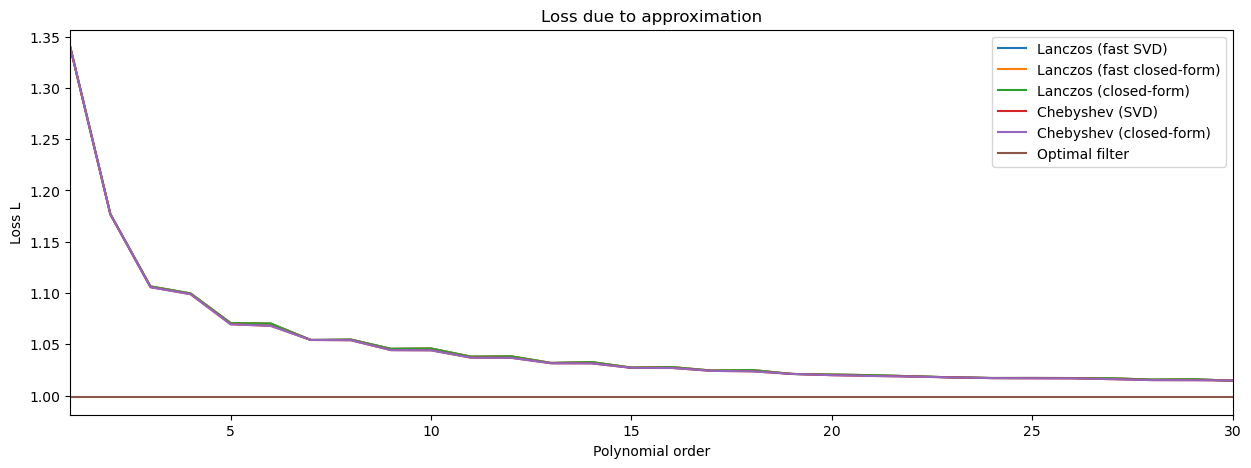

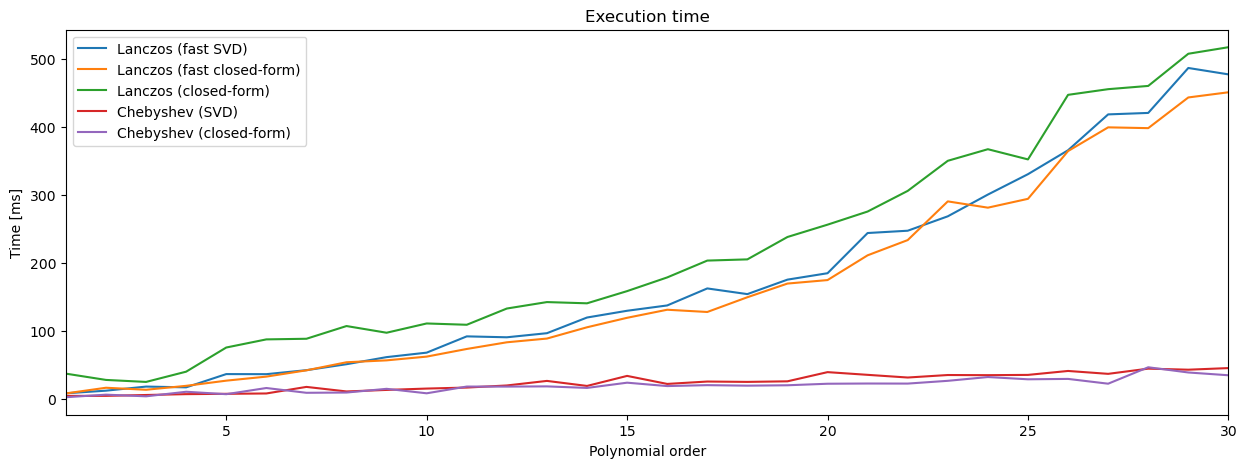

In [67]:
def polynomial_order(K, step=1):
    kk = np.arange(1, K+1, step)
    loss_lo = np.empty(len(kk))
    loss_ld = np.empty(len(kk))
    loss_lf = np.empty(len(kk))
    loss_cro = np.empty(len(kk))
    loss_crd = np.empty(len(kk))
    time_lo = np.empty(len(kk))
    time_ld = np.empty(len(kk))
    time_lf = np.empty(len(kk))
    time_cro = np.empty(len(kk))
    time_crd = np.empty(len(kk))
    
    for i, k in enumerate(kk):
        tstart = time.process_time()
        c_lo = basis_coeff_opt(lanczos_basis_eval, X, Y, k)
        loss_lo[i] = Lc(c_lo)
        time_lo[i] = time.process_time() - tstart
        
        tstart = time.process_time()
        c_ld = lanczos_coeff_direct(X, Y, k)
        loss_ld[i] = Lc(c_ld)
        time_ld[i] = time.process_time() - tstart
        
        tstart = time.process_time()
        c_lf = lanczos_coeff_direct_f(X, Y, k)
        loss_lf[i] = Lc_f(c_lf)
        time_lf[i] = time.process_time() - tstart
        
        tstart = time.process_time()
        c_cro = basis_coeff_opt(cheby_basis_eval, X, Y, k)
        loss_cro[i] = Lcr(c_cro)
        time_cro[i] = time.process_time() - tstart
        
        tstart = time.process_time()
        c_crd = cheby_coeff_direct(X, Y, k)
        loss_crd[i] = Lcr(c_crd)
        time_crd[i] = time.process_time() - tstart
        
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(kk, loss_lo, label='Lanczos (fast SVD)')
    ax.plot(kk, loss_ld, label='Lanczos (fast closed-form)')
    ax.plot(kk, loss_lf, label='Lanczos (closed-form)')
    ax.plot(kk, loss_cro, label='Chebyshev (SVD)')
    ax.plot(kk, loss_crd, label='Chebyshev (closed-form)')
    ax.plot(kk, L(c_o) * np.ones(len(kk)), label='Optimal filter')
    ax.set_title('Loss due to approximation')
    ax.set_ylabel('Loss L')
    ax.set_xlabel('Polynomial order')
    ax.set_xlim(1, K)
    ax.legend(loc='best')
    plt.show()
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(kk, time_lo * 1000, label='Lanczos (fast SVD)')
    ax.plot(kk, time_ld * 1000, label='Lanczos (fast closed-form)')
    ax.plot(kk, time_lf * 1000, label='Lanczos (closed-form)')
    ax.plot(kk, time_cro * 1000, label='Chebyshev (SVD)')
    ax.plot(kk, time_crd * 1000, label='Chebyshev (closed-form)')
    ax.set_title('Execution time')
    ax.set_ylabel('Time [ms]')
    ax.set_xlabel('Polynomial order')
    ax.set_xlim(1, K)
    ax.legend(loc='best')
    plt.show()

polynomial_order(30, 1)